This is built based on the preliminary result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ============================
# Reproducibility setup
# ============================

import os
import random
import numpy as np
import tensorflow as tf

SEED = 100

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# Hash seed (important!)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Force deterministic operations (TF 2.9+)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print("Reproducibility seed set to:", SEED)

kernel_init = tf.keras.initializers.GlorotUniform(seed=SEED)
recurrent_init = tf.keras.initializers.Orthogonal(seed=SEED)
embedding_init = tf.keras.initializers.RandomUniform(seed=SEED)

Reproducibility seed set to: 100


In [ ]:
image_folder = '/content/drive/MyDrive/AMLAA/VQA_RAD_Image_Folder'
excel_path = '/content/drive/MyDrive/AMLAA/VQA_RAD_Dataset_Public.xlsx'
import pandas as pd

df = pd.read_excel(excel_path)
print(df.head())

   QID_unique  QID_para                            QID_linked  \
0           0  freeform  03f451ca-de62-4617-9679-e836026a7642   
1           1  freeform  06e26b2c-04b9-42bc-8e98-1de30a0f7682   
2           2  freeform  0d0e8b6b-7753-4788-9b6d-dc7f25250c3f   
3           3  freeform  0e90b6bc-265f-490b-a039-509b9907a3cb   
4           4  freeform  1179f612-12e0-4dda-aee0-f14a5200be7b   

                                        IMAGEID_case  \
0  https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...   
1  https://medpix.nlm.nih.gov/case?id=b197277b-69...   
2  https://medpix.nlm.nih.gov/case?id=b197277b-69...   
3  https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...   
4  https://medpix.nlm.nih.gov/case?id=b197277b-69...   

                                             IMAGEID IMAGEORGAN  \
0  https://medpix.nlm.nih.gov/images/full/synpic5...       HEAD   
1  https://medpix.nlm.nih.gov/images/full/synpic2...      CHEST   
2  https://medpix.nlm.nih.gov/images/full/synpic2...      CHEST   
3  h

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Embedding, Concatenate, RepeatVector, TimeDistributed

# SOLVE MISSING DATA

In [ ]:
img_size = (224, 224)

def load_image(filename):
    img_path = os.path.join(image_folder, filename)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)

    return img

missing_answers = df[df['ANSWER'].isna() | (df['ANSWER'].astype(str).str.strip() == '')]

missing_answers[['QID_unique', 'QUESTION', 'ANSWER']]

QID_unique                                QUESTION ANSWER
334         334  What lesions are present in the lungs?    NaN

In [ ]:
# check if there are still missing value
mask = df['ANSWER'].isna() | (df['ANSWER'].astype(str).str.strip() == '')
df.loc[mask, 'ANSWER'] = 'No'
df.isna().sum()

QID_unique        0
QID_para          0
QID_linked        0
IMAGEID_case      0
IMAGEID           0
IMAGEORGAN        0
EVALUATION        0
QUESTION          0
Q_REPHASE       472
Q_RELATION      761
Q_FRAMED        981
Q_TYPE            0
ANSWER            0
A_TYPE            0
dtype: int64

#Normalise "YES" & "NO"

In [ ]:
unique_answers = df['ANSWER'].astype(str).str.strip().unique()
print("Total unique answers:", len(unique_answers))
unique_answers

Total unique answers: 556


array(['Yes', 'No', 'ultrasound', 'no', 'The extremities', 'yes',
       'left temporal lobe', 'Cardiovascular', 'vasculature',
       'MRI Diffusion Weighted', 'the brain', 'Posterior-Anterior',
       'Chest X-ray', 'Axial', 'Asymmetric', 'Pulmonary nodules',
       'Free air', 'hypodense lesion', 'GI', 'Ring-enhancing lesion',
       'Diffuse', 'CT', 'Chest x-ray', 'Pancreas', 'Right upper lobe',
       'Hypodense', 'Left hepatic lobe', 'Lungs', 'Bilateral',
       'Cirrhosis', 'Atherosclerotic calcification',
       'right parietal lobe', 'Chest', 'metastasis', 'axial', 'PA',
       'Enlarged', 'Volume loss', 'one',
       'extraluminal air and small fluid collection', 'Nodular opacities',
       'extra-axial and at the right choroidal fissure', 'Prior surgery',
       'Ring-enhancing lesions', 'right temporal lobe', 'Gallstones',
       'Right', 'abscess', 'Cystic lesions', 'middle mogul', 'Right lung',
       'enlarged, fluid-filled', 'Pancreatic body',
       'Right lobe of the 

In [ ]:
df['ANSWER'] = df['ANSWER'].astype(str).str.strip()

df.loc[df['ANSWER'].str.lower() == 'yes', 'ANSWER'] = 'Yes'
df.loc[df['ANSWER'].str.lower() == 'no',  'ANSWER'] = 'No'

df['ANSWER'].value_counts()

ANSWER
No                                                                            607
Yes                                                                           587
Axial                                                                          28
Right                                                                          22
Left                                                                           18
                                                                             ... 
Cartilage is not well viewed by x rays                                          1
Lung markings present all the way laterally to the ribs                         1
The right mainstem bronchus is more in line with the trachea than the left      1
Right PICA                                                                      1
L2                                                                              1
Name: count, Length: 553, dtype: int64

# CHECK ANSWER TYPE

In [ ]:
df['A_TYPE'] = df['A_TYPE'].str.lower()

df['A_TYPE'].value_counts()


A_TYPE
closed     1297
open        949
closed        2
Name: count, dtype: int64

In [ ]:
df['A_TYPE'] = df['A_TYPE'].astype(str).str.lower().str.strip()
df['A_TYPE'].value_counts()


A_TYPE
closed    1299
open       949
Name: count, dtype: int64

In [ ]:
# Unique values of closed answer
closed_answers = df[df['A_TYPE'] == 'closed']['ANSWER'].unique()

print("Number of unique closed answers:", len(closed_answers))
closed_answers


Number of unique closed answers: 69


array(['Yes', 'No', 'Asymmetric', 'Diffuse', 'Hypodense', 'Enlarged',
       'one', 'Superior', 'Left side', 'Small bowel', 'Left kidney',
       'Both', 'more dense', 'less dense', 'surrounding tissue',
       'Less dense', 'The surrounding tissue', 'Right side', 'Left',
       'Smaller', 'Just one', 'Solid', 'supratentorial', 'Female',
       'White matter', 'Abscess', 'Medical process', 'PA', 'MRI',
       'Contrast CT with GI and IV contrast', 'Non-contrast CT',
       'With contrast', 'heterogeneous', 'with contrast', 'Right',
       'Bilateral frontal lobes', 'Hyperintense', 'contrast',
       'multilobulated', 'In the vasculature', 'Heterogeneous', 'Cystic',
       'Abnormal', 'In the bowels', 'Radiolucent', 'Bilateral', 'CT',
       'Non-enhanced', 'AP', 'FLAIR', 'Normal', 'Base', 'Axial',
       'non-contrast', 'Hyperinflation', 'abnormal', 'pleural effusion',
       'genetic', 'Vascular', 'Not sure', 'Maybe', 'Gray matter',
       'bilateral', 'both sides', 'Exterior', 'Outsi

In [ ]:
df[df['A_TYPE'] == 'closed']['ANSWER'].value_counts()

ANSWER
No                                   606
Yes                                  587
FLAIR                                  5
Left                                   4
PA                                     4
                                    ... 
Exterior                               1
Outside                                1
Irregular                              1
On top of the patient                  1
superficial to the patient's skin      1
Name: count, Length: 69, dtype: int64

# SEPARATE CLOSE AND OPEN ANSWER

In [ ]:
# separate close and open answer
# CLOSED answers
df_closed = df[df['A_TYPE'] == 'closed'].reset_index(drop=True)
closed_questions = df_closed['QUESTION'].tolist()
closed_answers = df_closed['ANSWER'].tolist()

# OPEN answers
df_open = df[df['A_TYPE'] != 'closed'].reset_index(drop=True)
open_questions = df_open['QUESTION'].tolist()
open_answers = df_open['ANSWER'].tolist()


In [ ]:
print("Number of closed questions:", len(closed_questions))
print("Sample closed questions:", closed_questions[:5])

Number of closed questions: 1299
Sample closed questions: ['Are regions of the brain infarcted?', 'Are the lungs normal appearing?', 'Is there evidence of a pneumothorax', 'Is this a MRI of the chest?', 'Is the trachea midline?']


# TOKENISE AND PAD QUESTION

In [ ]:
# tokenize and pad question
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# CLOSED questions
tokenizer_q_closed = Tokenizer()
tokenizer_q_closed.fit_on_texts(closed_questions)
q_seq_closed = tokenizer_q_closed.texts_to_sequences(closed_questions)
q_padded_closed = pad_sequences(q_seq_closed, padding='post')

In [ ]:
# OPEN questions
tokenizer_q_open = Tokenizer()
tokenizer_q_open.fit_on_texts(open_questions)
q_seq_open = tokenizer_q_open.texts_to_sequences(open_questions)
q_padded_open = pad_sequences(q_seq_open, padding='post')

# PREPROCESS ANSWER

In [ ]:
# encode closed answer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le_closed = LabelEncoder()
closed_cat = le_closed.fit_transform(closed_answers)
closed_cat = to_categorical(closed_cat)

In [ ]:
# Number of NaN values
num_null = df_open['ANSWER'].isna().sum()

print("Number of NaN answers:", num_null)

# Replace missing answers with empty string
df_open['ANSWER'] = df_open['ANSWER'].fillna('')
open_answers = df_open['ANSWER'].astype(str).tolist()

Number of NaN answers: 0


In [ ]:
# TOKENISE ANSWER OPEN

tokenizer_a_open = Tokenizer()
tokenizer_a_open.fit_on_texts(open_answers)
a_seq_open = tokenizer_a_open.texts_to_sequences(open_answers)
a_padded = pad_sequences(a_seq_open, padding='post')

# PAIR IMAGE TO QUESTION

In [ ]:
# Load images and pair with questions/answers
# CLOSED
# X_images_closed, X_q_closed, y_closed_final = [], [], []

# for idx, row in df_closed.iterrows():
#     img_file = os.path.basename(row['IMAGEID'])
#     img = load_image(img_file)
#     if img is None:
#         continue
#     X_images_closed.append(img)
#     X_q_closed.append(q_padded_closed[idx])
#     y_closed_final.append(closed_cat[idx])

# X_images_closed = np.array(X_images_closed)
# X_q_closed = np.array(X_q_closed)
# y_closed_final = np.array(y_closed_final)

# ---------------- CLOSED ----------------
X_images_closed, X_q_closed, y_closed_final = [], [], []

for idx, row in tqdm(
    df_closed.iterrows(),
    total=len(df_closed),
    desc="Loading CLOSED"
):
    img_file = os.path.basename(row['IMAGEID'])
    img = load_image(img_file)
    if img is None:
        continue

    X_images_closed.append(img)
    X_q_closed.append(q_padded_closed[idx])
    y_closed_final.append(closed_cat[idx])

X_images_closed = np.array(X_images_closed, dtype=np.float32)
X_q_closed = np.array(X_q_closed)
y_closed_final = np.array(y_closed_final)

# # OPEN
# X_images_open, X_q_open, y_open_final = [], [], []

# for idx, row in df_open.iterrows():
#     img_file = os.path.basename(row['IMAGEID'])
#     img = load_image(img_file)
#     if img is None:
#         continue
#     X_images_open.append(img)
#     X_q_open.append(q_padded_open[idx])
#     y_open_final.append(a_padded[idx])

# X_images_open = np.array(X_images_open)
# X_q_open = np.array(X_q_open)
# y_open_final = np.array(y_open_final)

# ---------------- OPEN ----------------
X_images_open, X_q_open, y_open_final = [], [], []

for idx, row in tqdm(
    df_open.iterrows(),
    total=len(df_open),
    desc="Loading OPEN"
):
    img_file = os.path.basename(row['IMAGEID'])
    img = load_image(img_file)
    if img is None:
        continue

    X_images_open.append(img)
    X_q_open.append(q_padded_open[idx])
    y_open_final.append(a_padded[idx])

X_images_open = np.array(X_images_open, dtype=np.float32)
X_q_open = np.array(X_q_open)
y_open_final = np.array(y_open_final)

Loading OPEN: 100%|██████████| 949/949 [00:09<00:00, 95.66it/s] 


In [ ]:
from sklearn.model_selection import train_test_split

# ---- CLOSED ----
X_img_train_c, X_img_test_c, X_q_train_c, X_q_test_c, y_train_c, y_test_c = train_test_split(
    X_images_closed, X_q_closed, y_closed_final, test_size=0.2, random_state=SEED
)

# ---- OPEN ----
X_img_train_o, X_img_test_o, X_q_train_o, X_q_test_o, y_train_o, y_test_o = train_test_split(
    X_images_open, X_q_open, y_open_final, test_size=0.2, random_state=SEED
)

# EARLY STOP SETTING

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# ----------------------------
# 1️⃣ Early Stopping
# ----------------------------
early_stop = EarlyStopping(
    monitor='val_accuracy',   # monitor validation accuracy
    patience=8,               # stop if no improvement for 8 epochs
    verbose=1,
    restore_best_weights=True # always restore the best model
)

# # ----------------------------
# # 2️⃣ Model Checkpoint
# # ----------------------------
# checkpoint = ModelCheckpoint(
#     'best_vqa_model.h5',     # save best model
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# ----------------------------
# 3️⃣ Reduce learning rate on plateau
# ----------------------------
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # reduce LR by half
    patience=5,              # after 5 epochs of no improvement
    verbose=1,
    min_lr=1e-6
)

def create_training_callbacks(base_name):
    """
    base_name: str
        Example: 'model_closed', 'model_open', 'model_vqa'
    """
    checkpoint = ModelCheckpoint(
        filepath=f"{base_name}.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    csv_logger = CSVLogger(
        filename=f"{base_name}.csv",
        append=True
    )

    return checkpoint, csv_logger


def save_model_visualization(model):
    """
    model: tf.keras.Model
    base_name: str (e.g., 'model_1_closed', 'model_open')
    """
    plot_model(
        model,
        to_file=f"{model}_visualization.png",
        show_shapes=True,
        show_layer_names=True
    )


# MODEL 1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import LSTM, Embedding, Concatenate, RepeatVector, TimeDistributed

##model 1 closed

In [ ]:
#Model for CLOSED answers (classification)
#nputs: image + question
# Outputs: categorical answer (one-hot)

# Image input
img_input_c = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3,3), activation='relu', kernel_initializer=kernel_init)(img_input_c)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# Question input
q_input_c = Input(shape=(X_q_train_c.shape[1],), name='question_input')
q = Embedding(input_dim=len(tokenizer_q_closed.word_index)+1, output_dim=64,embeddings_initializer=embedding_init)(q_input_c)
q = LSTM(64,kernel_initializer=kernel_init,recurrent_initializer=recurrent_init)(q)

# Combine image + question features
combined = Concatenate()([x, q])
out_c = Dense(y_train_c.shape[1], activation='softmax', kernel_initializer=kernel_init )(combined)

model_1_closed = Model(inputs=[img_input_c, q_input_c], outputs=out_c)
model_1_closed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1_closed.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 21, 64)    │     56,128 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 186624)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 186688)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 69)        │ 12,881,541 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,990,085 (49.55 MB)

 Trainable params: 12,990,085 (49.55 MB)

 Non-trainable params: 0 (0.00 B)

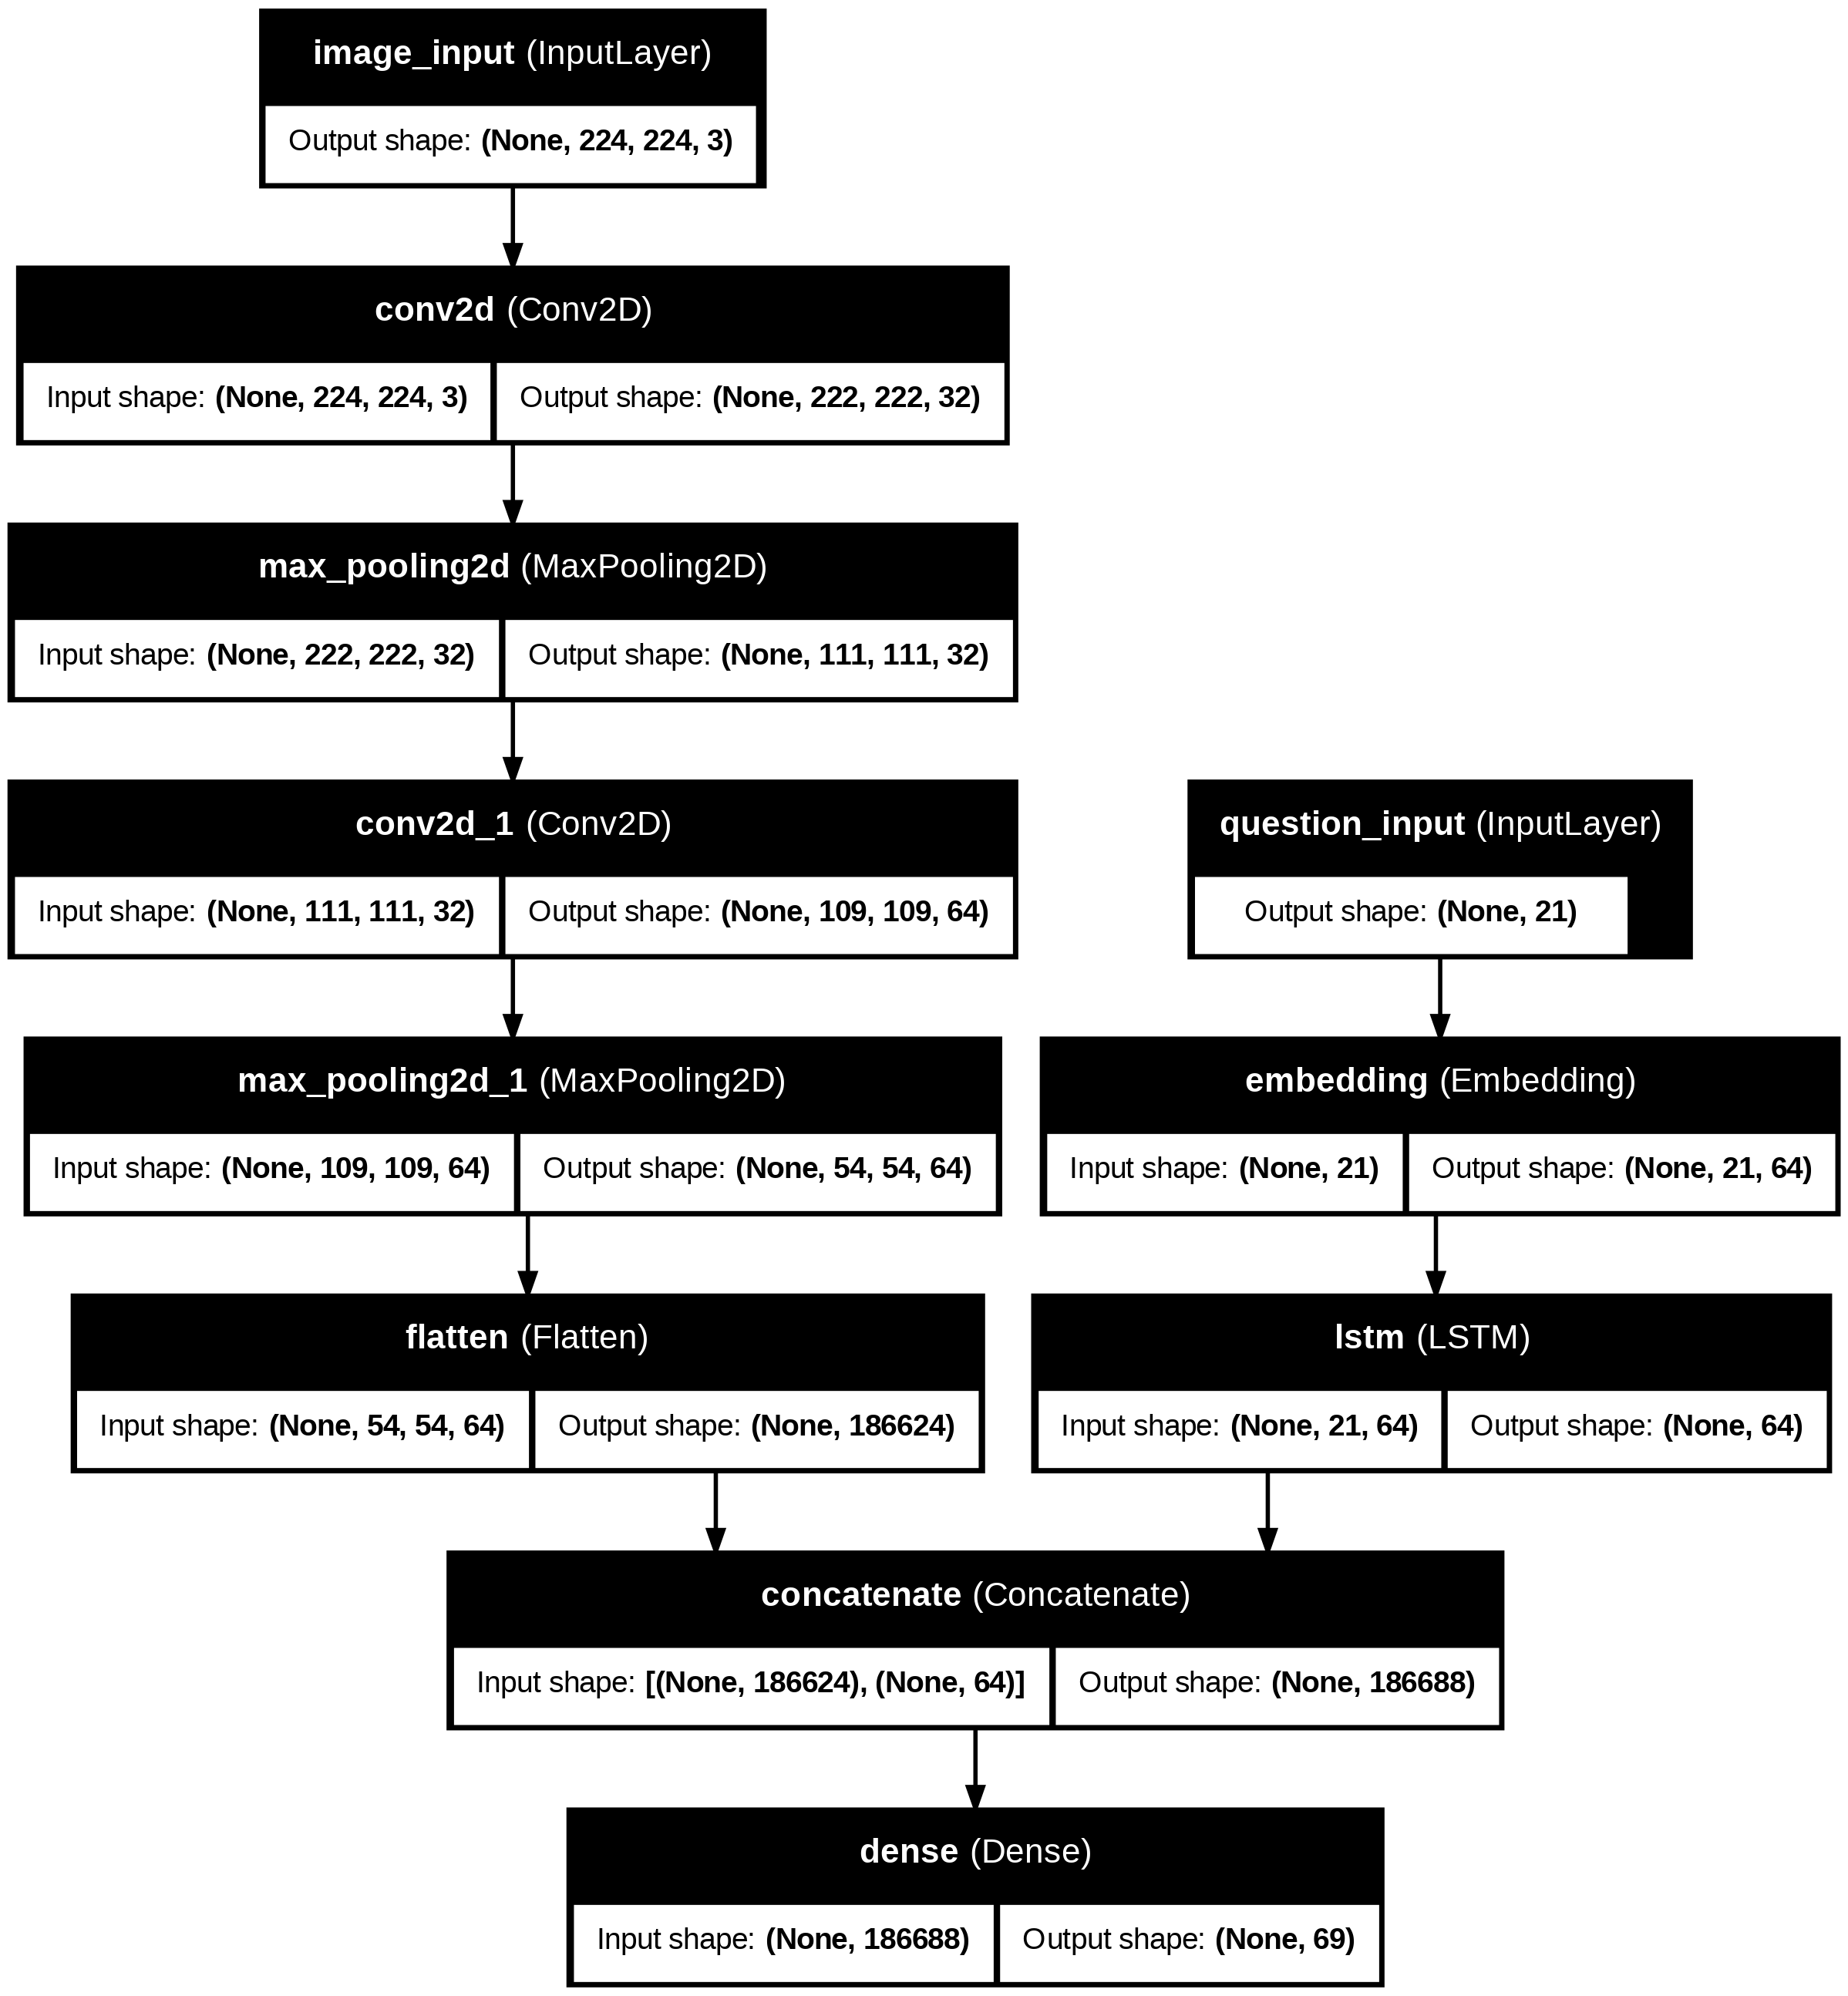

In [ ]:
# from tensorflow.keras.utils import plot_model
# # Plot the model

plot_model(
    model_1_closed,
    to_file='model_1_closed_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

#save_model_visualization(model_1_closed)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_1_closed")

history = model_1_closed.fit(
    [X_img_train_c, X_q_train_c],   # training inputs
    y_train_c,                                 # labels
    validation_data=([X_img_test_c, X_q_test_c], y_test_c),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3672 - loss: 260.7248
Epoch 1: val_accuracy improved from -inf to 0.57308, saving model to model_1_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3699 - loss: 256.7398 - val_accuracy: 0.5731 - val_loss: 2.4097 - learning_rate: 0.0010
Epoch 2/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6033 - loss: 1.7238
Epoch 2: val_accuracy did not improve from 0.57308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6039 - loss: 1.6935 - val_accuracy: 0.5500 - val_loss: 1.7462 - learning_rate: 0.0010
Epoch 3/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6104 - loss: 1.1357
Epoch 3: val_accuracy improved from 0.57308 to 0.59615, saving model to model_1_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6122 - loss: 1.1271 - val_accuracy: 0.5962 - val_loss: 1.5188 - learning_rate: 0.0010
Epoch 4/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6199 - loss: 0.9253
Epoch 4: val_accuracy did not improve from 0.59615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6215 - loss: 0.9245 - val_accuracy: 0.5962 - val_loss: 1.5741 - learning_rate: 0.0010
Epoch 5/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6263 - loss: 0.9777
Epoch 5: val_accuracy did not improve from 0.59615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6289 - loss: 0.9721 - val_accuracy: 0.5846 - val_loss: 1.6990 - learning_rate: 0.0010
Epoch 6/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6134 - loss: 0.8752
Epoch 6: val_accuracy did not improve from 0.59615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6154 - loss: 0.8748 - val_accuracy: 0.5885 - val_loss: 1.7254 - learning_rate: 0.0010
Epoch 7/100
31/33 ━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6424 - loss: 0.8116 - val_accuracy: 0.6077 - val_loss: 1.5134 - learning_rate: 0.0010
Epoch 9/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6367 - loss: 0.8710
Epoch 9: val_accuracy improved from 0.60769 to 0.61538, saving model to model_1_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6385 - loss: 0.8672 - val_accuracy: 0.6154 - val_loss: 1.6785 - learning_rate: 0.0010
Epoch 10/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6457 - loss: 0.8726
Epoch 10: val_accuracy did not improve from 0.61538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6479 - loss: 0.8674 - val_accuracy: 0.5577 - val_loss: 2.1284 - learning_rate: 0.0010
Epoch 11/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6286 - loss: 0.9120
Epoch 11: val_accuracy did not improve from 0.61538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6309 - loss: 0.9110 - val_accuracy: 0.5885 - val_loss: 1.5896 - learning_rate: 0.0010
Epoch 12/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6751 - loss: 0.8054
Epoch 12: val_accuracy did not improve from 0.61538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6744 - loss: 0.8073 - val_accuracy: 0.5923 - val_loss: 1.5089 - learning_rate: 0.0010
Epoch 13/100
31/33 ━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6661 - loss: 0.7634 - val_accuracy: 0.6231 - val_loss: 1.4935 - learning_rate: 0.0010
Epoch 16/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6660 - loss: 0.7860
Epoch 16: val_accuracy did not improve from 0.62308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6676 - loss: 0.7823 - val_accuracy: 0.6115 - val_loss: 1.5517 - learning_rate: 0.0010
Epoch 17/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6648 - loss: 0.7953
Epoch 17: val_accuracy did not improve from 0.62308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6642 - loss: 0.7932 - val_accuracy: 0.6077 - val_loss: 1.7498 - learning_rate: 0.0010
Epoch 18/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6632 - loss: 0.8414
Epoch 18: val_accuracy did not improve from 0.62308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6648 - loss: 0.8352 - val_accuracy: 0.5769 - val_loss: 2.0144 - learning_rate: 0.0010
Epoch 19/100
31/33 ━━━━

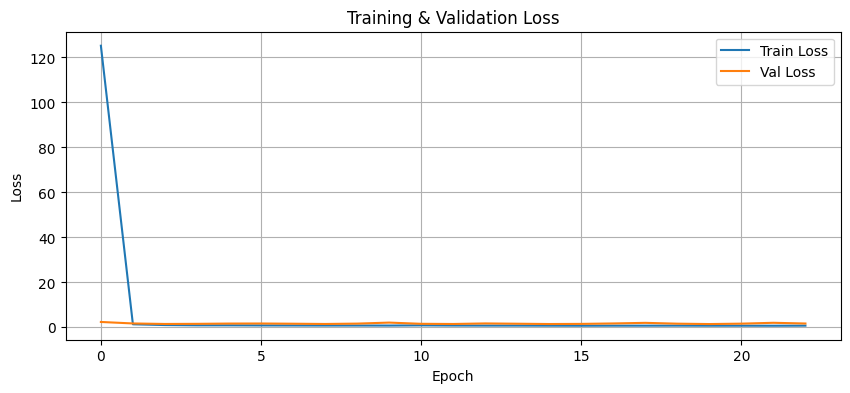

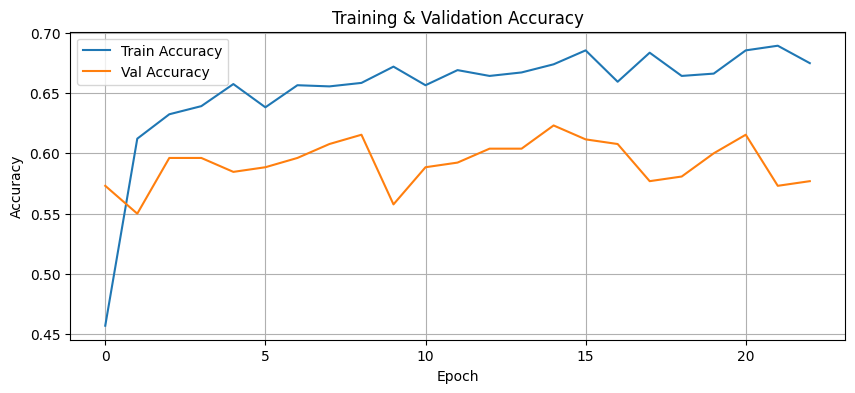

In [ ]:
# Load the CSV log
log = pd.read_csv('model_1_closed.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##model 1 open

In [ ]:

def masked_sparse_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred
    )
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
# ---------------- Image branch ----------------
img_input_o = Input(shape=(224, 224, 3), name='image_input_open')

x = Conv2D(32, (3,3), activation='relu', kernel_initializer=kernel_init)(img_input_o)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu',  kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# ---------------- Question branch ----------------
q_input_o = Input(shape=(X_q_train_o.shape[1],), name='question_input_open')

q = Embedding(
    input_dim=len(tokenizer_q_open.word_index) + 1,
    output_dim=64,
    mask_zero=True,
    embeddings_initializer=embedding_init
)(q_input_o)

q = LSTM(64, kernel_initializer=kernel_init,recurrent_initializer=recurrent_init)(q)

# ---------------- Combine ----------------
combined_o = Concatenate()([x, q])

timesteps = y_train_o.shape[1]  # 17
combined_o = RepeatVector(timesteps)(combined_o)

# ---------------- Output (OPEN answers) ----------------
vocab_size_open = len(tokenizer_a_open.word_index) + 1

#out_o = Dense(vocab_size_open, activation='softmax')(combined_o)

out_o = TimeDistributed(Dense(vocab_size_open, activation='softmax', kernel_initializer=kernel_init))(combined_o)

# combined_o = Concatenate()([x, q])
# out_o = Dense(17, activation='softmax')(combined_o)

# num_classes = len(tokenizer_a_open.word_index) + 1

# # Combine features
# combined_o = Concatenate()([x, q])

# # Output layer
# out_o = Dense(num_classes, activation='softmax')(combined_o)


# ---------------- Model ----------------
model_1_open = Model(
    inputs=[img_input_o, q_input_o],
    outputs=out_o
)

model_1_open.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',# masked_sparse_categorical_crossentropy,#'sparse_categorical_crossentropy',#'categorical_crossentropy',
    metrics=['accuracy']
)

model_1_open.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input_open    │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │        896 │ image_input_open… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input_open │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 22, 64)    │     45,248 │ question_input_o… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 22)        │          0 │ question_input_o… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_1[0][0… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 186688)    │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 17,        │          0 │ concatenate_1[0]… │
│ (RepeatVector)      │ 186688)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 17, 600)   │ 112,013,4… │ repeat_vector[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,111,064 (427.67 MB)

 Trainable params: 112,111,064 (427.67 MB)

 Non-trainable params: 0 (0.00 B)

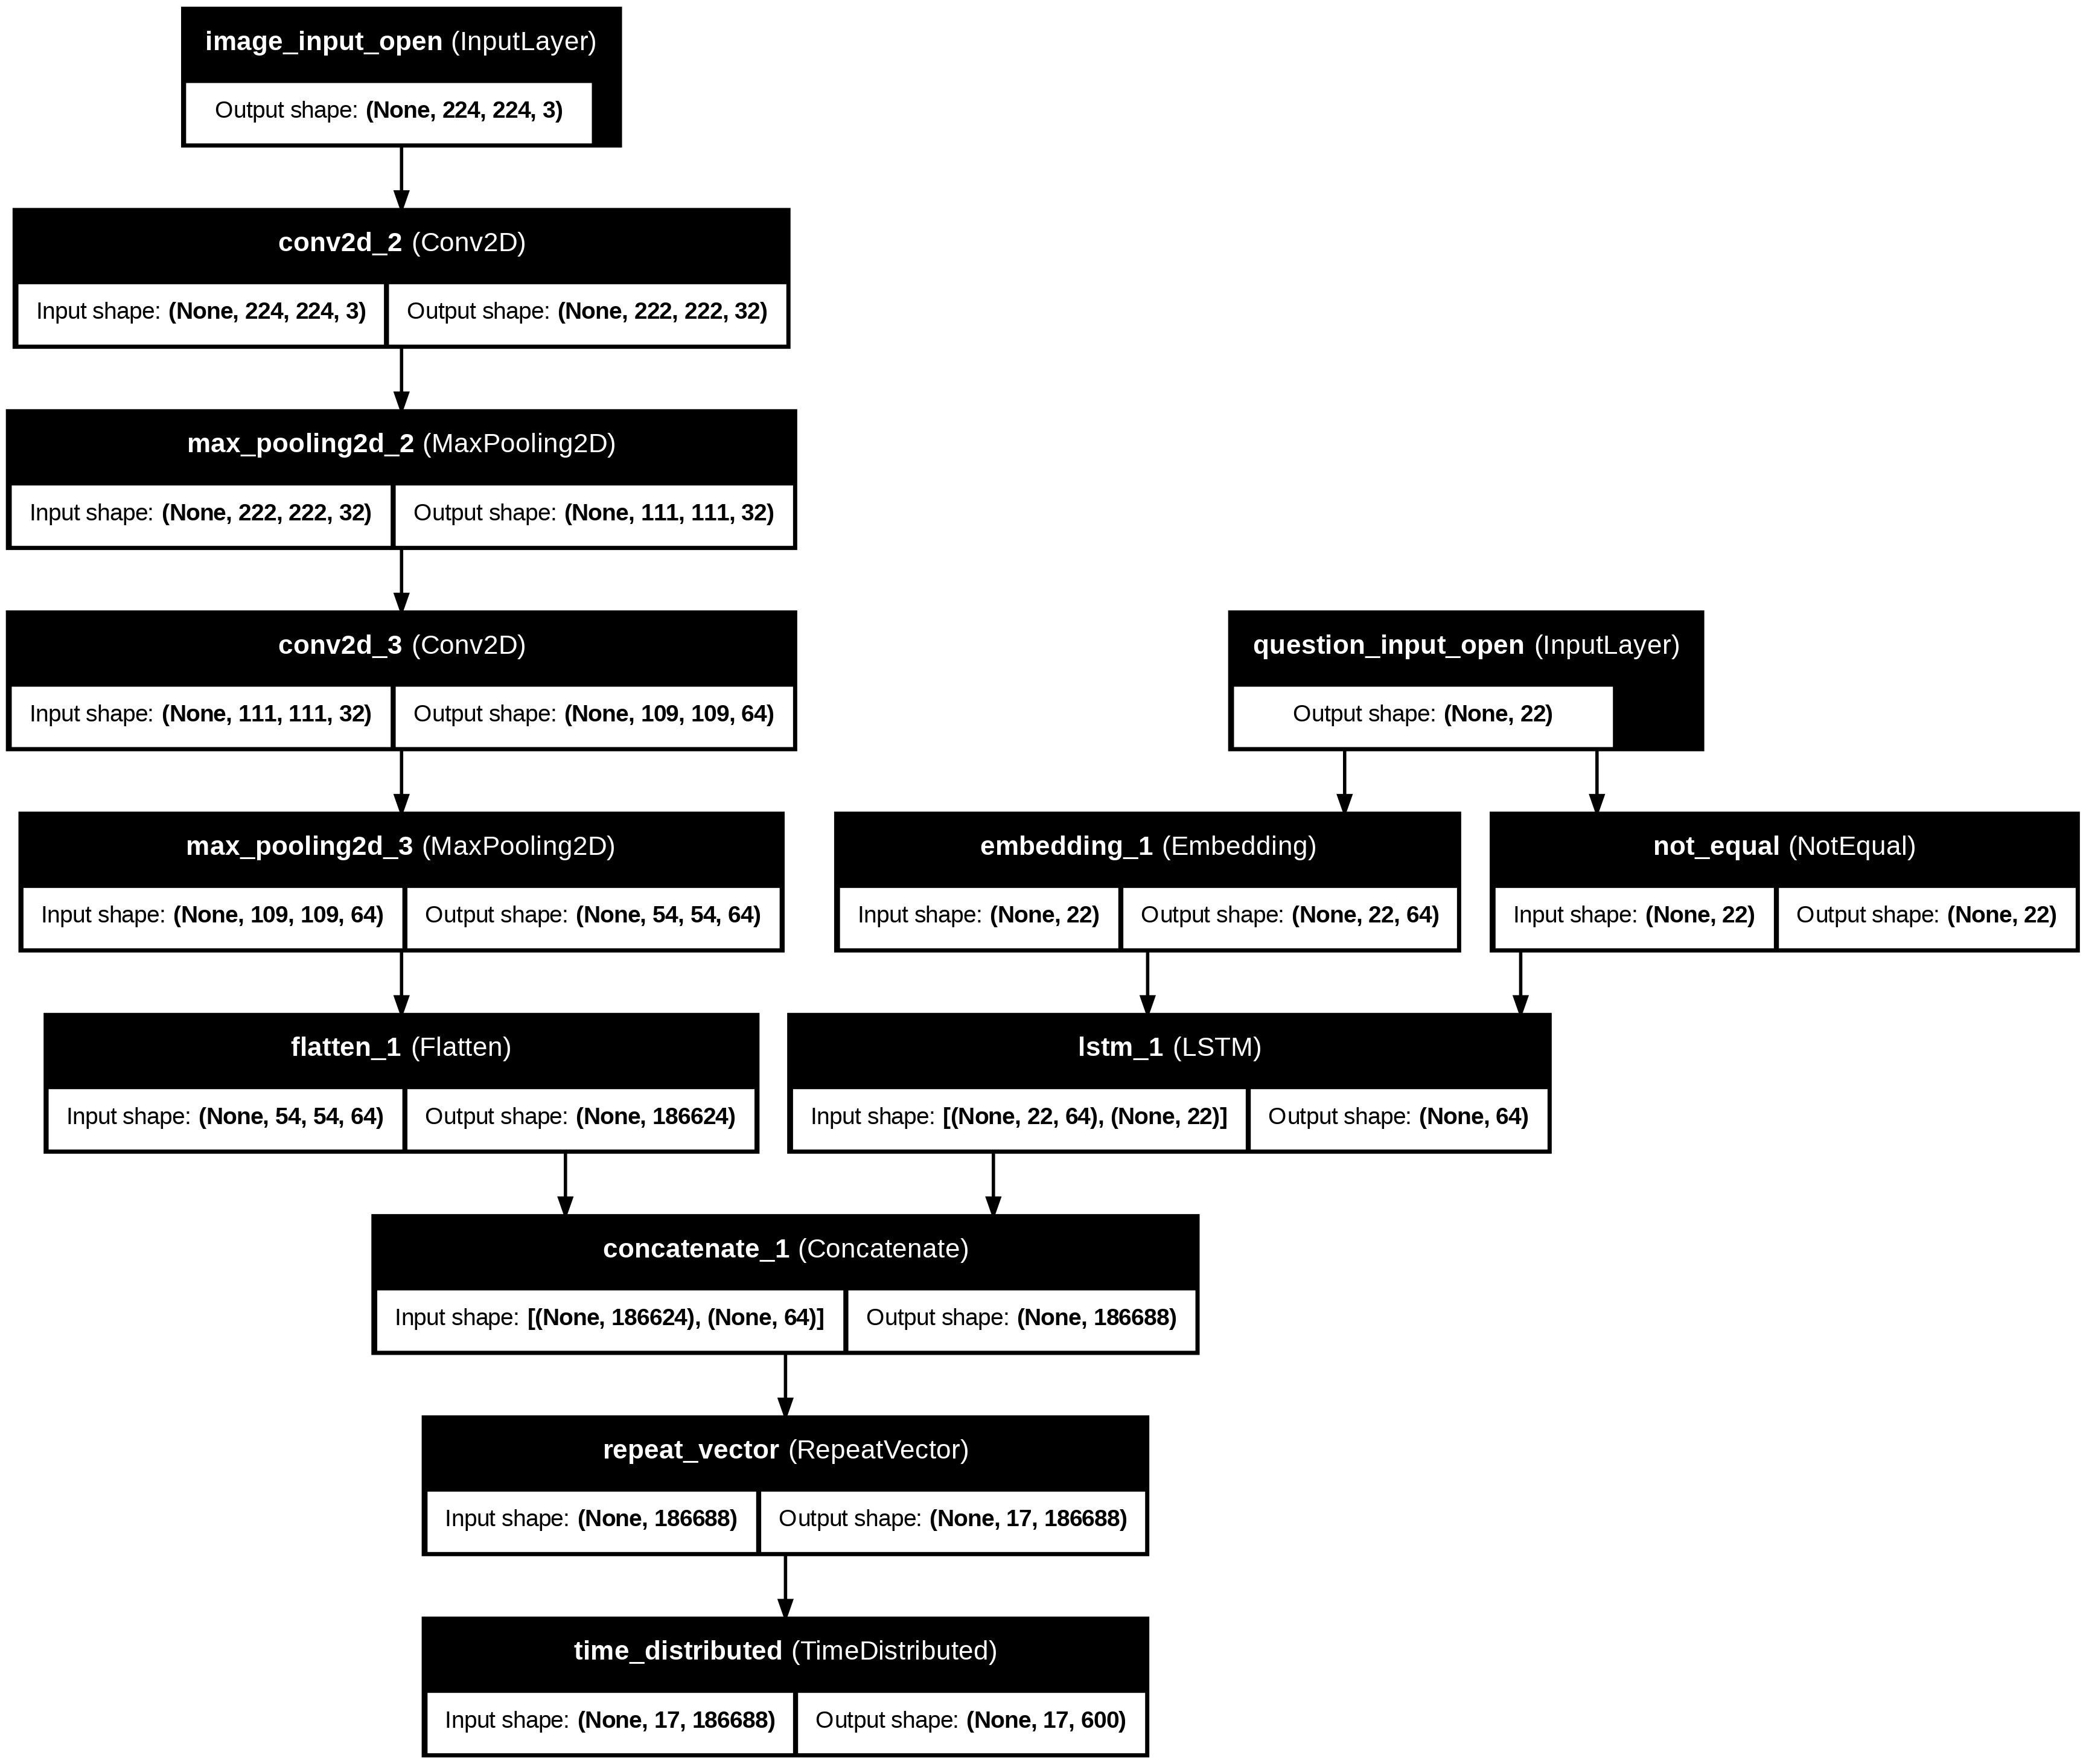

In [ ]:
plot_model(
    model_1_open,
    to_file='model_1_open_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
print("Shape of y_train_o:", y_train_o.shape)
print("Unique values in y_train_o:", np.unique(y_train_o))

Shape of y_train_o: (759, 17)
Unique values in y_train_o: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 212 213 214 215 216
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 2

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_1_open")



history = model_1_open.fit(
    [X_img_train_o, X_q_train_o],   # training inputs
    y_train_o,                                 # labels
    validation_data=([X_img_test_o, X_q_test_o], y_test_o),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0011 - loss: 16.0984
Epoch 1: val_accuracy improved from -inf to 0.00093, saving model to model_1_open.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.0011 - loss: 16.0985 - val_accuracy: 9.2879e-04 - val_loss: 16.1032 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0014 - loss: 16.0958
Epoch 2: val_accuracy did not improve from 0.00093
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.0014 - loss: 16.0960 - val_accuracy: 9.2879e-04 - val_loss: 16.1032 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0014 - loss: 16.0958
Epoch 3: val_accuracy did not improve from 0.00093
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.0014 - loss: 16.0960 - val_accuracy: 9.2879e-04 - val_loss: 16.1032 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0014 - loss: 16.0958
Epoch 4: val_accuracy did not improve from 0.00093
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.0014 - loss: 16.0960 - val_accuracy: 9.2879e-04 - val_loss: 16.1032 - learning_rate: 0.0010


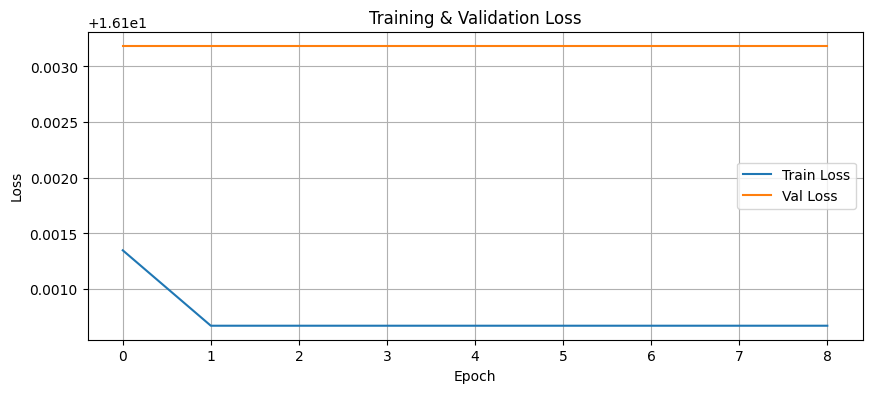

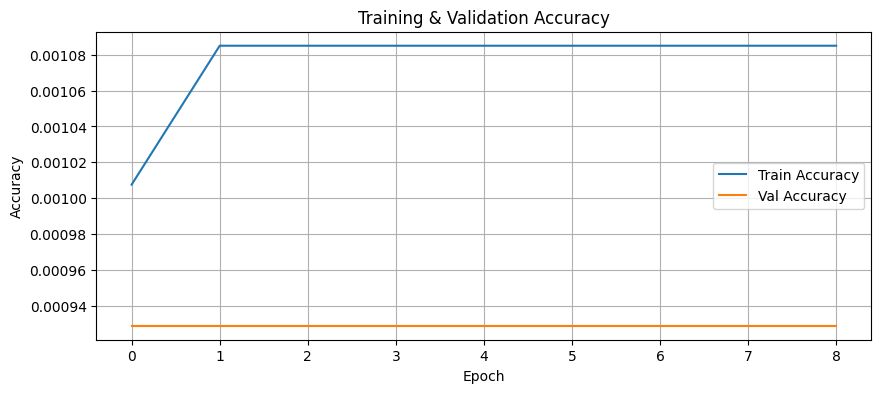

In [ ]:
# Load the CSV log
log = pd.read_csv('model_1_open.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# MODEL 2

## model 2 closed

In [ ]:
# Image input
img_input_c = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3,3), activation='relu', kernel_initializer=kernel_init)(img_input_c)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# Question input
q_input_c = Input(shape=(X_q_train_c.shape[1],), name='question_input')
q = Embedding(input_dim=len(tokenizer_q_closed.word_index)+1, output_dim=64,embeddings_initializer=embedding_init)(q_input_c)
q = LSTM(64,kernel_initializer=kernel_init,recurrent_initializer=recurrent_init)(q)

# Combine image + question features
combined = Concatenate()([x, q])
out_c = Dense(y_train_c.shape[1], activation='softmax',kernel_initializer=kernel_init)(combined)

model_2_closed = Model(inputs=[img_input_c, q_input_c], outputs=out_c)
model_2_closed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2_closed.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 21, 64)    │     56,128 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 86528)     │          0 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     33,024 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 86592)     │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 69)        │  5,974,917 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,157,317 (23.49 MB)

 Trainable params: 6,157,317 (23.49 MB)

 Non-trainable params: 0 (0.00 B)

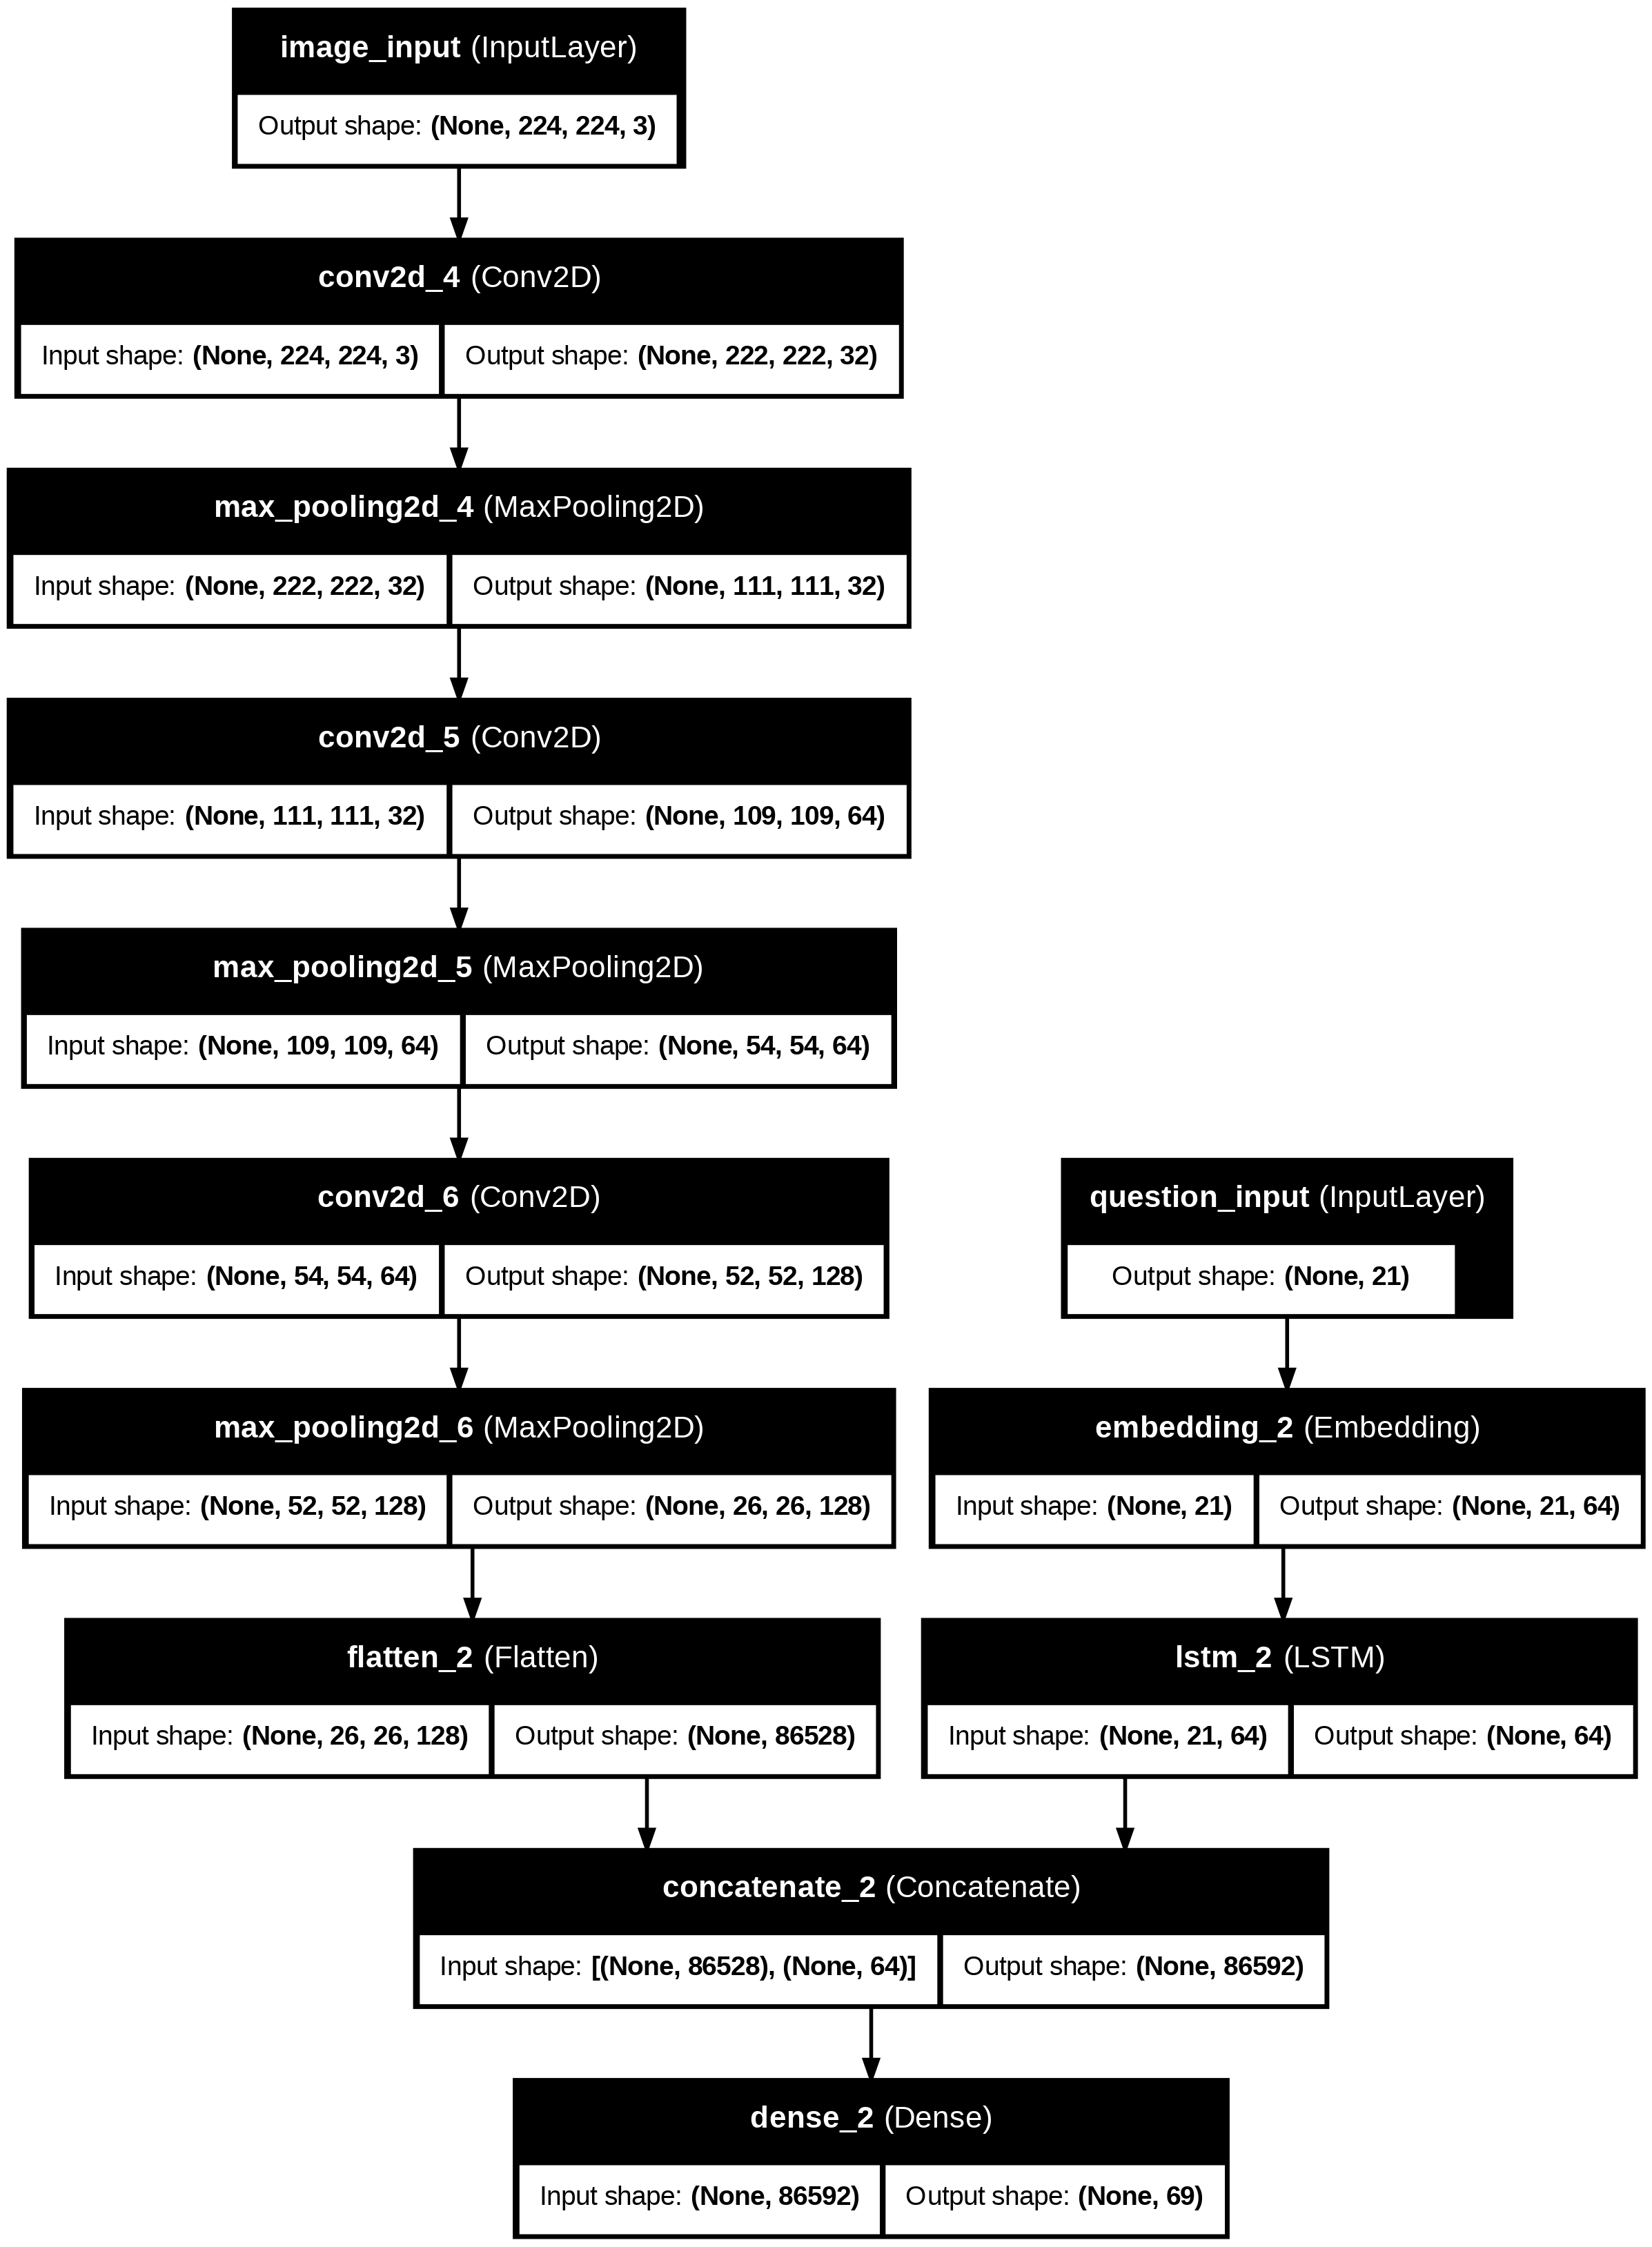

In [ ]:
#save_model_visualization(model_2_closed)

plot_model(
    model_2_closed,
    to_file='model_2_closed_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_2_closed")

history = model_2_closed.fit(
    [X_img_train_c, X_q_train_c],   # training inputs
    y_train_c,                                 # labels
    validation_data=([X_img_test_c, X_q_test_c], y_test_c),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3841 - loss: 48.2695
Epoch 1: val_accuracy improved from -inf to 0.52692, saving model to model_2_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3861 - loss: 47.4836 - val_accuracy: 0.5269 - val_loss: 1.2250 - learning_rate: 0.0010
Epoch 2/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5855 - loss: 1.2390
Epoch 2: val_accuracy improved from 0.52692 to 0.57308, saving model to model_2_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5856 - loss: 1.2355 - val_accuracy: 0.5731 - val_loss: 1.2485 - learning_rate: 0.0010
Epoch 3/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6327 - loss: 1.0446
Epoch 3: val_accuracy did not improve from 0.57308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6350 - loss: 1.0389 - val_accuracy: 0.5385 - val_loss: 1.6799 - learning_rate: 0.0010
Epoch 4/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6394 - loss: 0.9414
Epoch 4: val_accuracy did not improve from 0.57308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6406 - loss: 0.9390 - val_accuracy: 0.5654 - val_loss: 1.4428 - learning_rate: 0.0010
Epoch 5/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6247 - loss: 0.8232
Epoch 5: val_accuracy improved from 0.57308 to 0.60769, saving model to model_2_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6289 - loss: 0.8180 - val_accuracy: 0.6077 - val_loss: 1.4481 - learning_rate: 0.0010
Epoch 6/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6826 - loss: 0.6768
Epoch 6: val_accuracy improved from 0.60769 to 0.63462, saving model to model_2_closed.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6839 - loss: 0.6768 - val_accuracy: 0.6346 - val_loss: 1.3876 - learning_rate: 0.0010
Epoch 7/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7177 - loss: 0.6054
Epoch 7: val_accuracy did not improve from 0.63462
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7189 - loss: 0.6041 - val_accuracy: 0.6192 - val_loss: 1.4838 - learning_rate: 5.0000e-04
Epoch 8/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7322 - loss: 0.5683
Epoch 8: val_accuracy did not improve from 0.63462
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7330 - loss: 0.5671 - val_accuracy: 0.6077 - val_loss: 1.5466 - learning_rate: 5.0000e-04
Epoch 9/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7347 - loss: 0.5589
Epoch 9: val_accuracy improved from 0.63462 to 0.63846, saving model to model_2_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7362 - loss: 0.5572 - val_accuracy: 0.6385 - val_loss: 1.5702 - learning_rate: 5.0000e-04
Epoch 10/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7332 - loss: 0.5535
Epoch 10: val_accuracy did not improve from 0.63846
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7347 - loss: 0.5509 - val_accuracy: 0.6308 - val_loss: 1.6071 - learning_rate: 5.0000e-04
Epoch 11/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7330 - loss: 0.5484
Epoch 11: val_accuracy improved from 0.63846 to 0.64615, saving model to model_2_closed.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7353 - loss: 0.5458 - val_accuracy: 0.6462 - val_loss: 1.6749 - learning_rate: 5.0000e-04
Epoch 12/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7441 - loss: 0.5049
Epoch 12: val_accuracy did not improve from 0.64615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7458 - loss: 0.5017 - val_accuracy: 0.6000 - val_loss: 1.8123 - learning_rate: 2.5000e-04
Epoch 13/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7547 - loss: 0.4852
Epoch 13: val_accuracy did not improve from 0.64615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7563 - loss: 0.4828 - val_accuracy: 0.6231 - val_loss: 1.8526 - learning_rate: 2.5000e-04
Epoch 14/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7669 - loss: 0.4605
Epoch 14: val_accuracy did not improve from 0.64615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7680 - loss: 0.4590

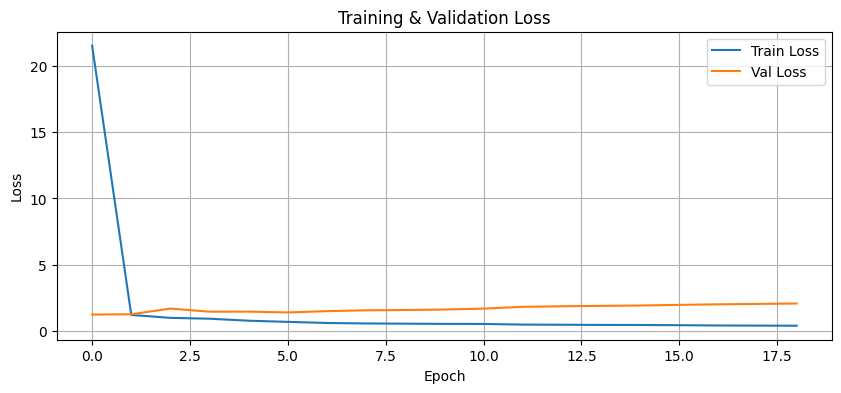

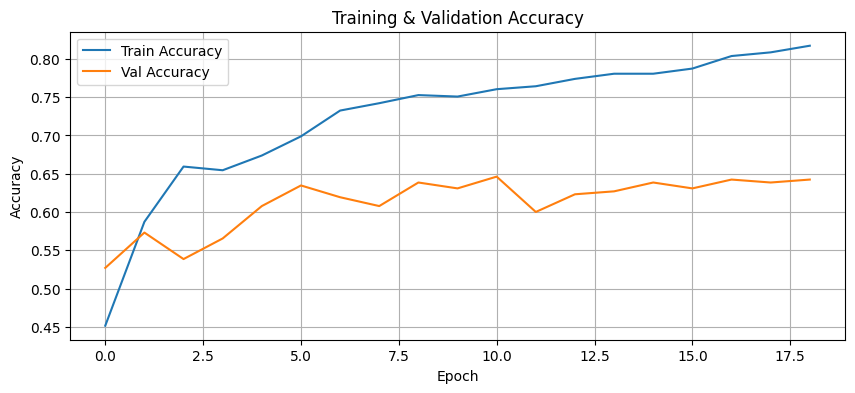

In [ ]:
# Load the CSV log
log = pd.read_csv('model_2_closed.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##model 2 open

In [ ]:
# ---- Image input branch ----
img_input_o = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3,3), activation='relu',kernel_initializer=kernel_init)(img_input_o)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu',kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu',kernel_initializer=kernel_init)(x)
x = RepeatVector(y_train_o.shape[1])(x)  # repeat for each answer token

# ---- Question input branch ----
q_input_o = Input(shape=(X_q_train_o.shape[1],), name='question_input')
q = Embedding(input_dim=len(tokenizer_q_open.word_index)+1, output_dim=64,embeddings_initializer=embedding_init)(q_input_o)
q = LSTM(128, return_sequences=False, kernel_initializer=kernel_init, recurrent_initializer=recurrent_init)(q)  # output 2D
q = RepeatVector(y_train_o.shape[1])(q)   # repeat for each answer token

# ---- Combine image + question ----
combined_o = Concatenate(axis=-1)([x, q])
out_o = TimeDistributed(Dense(len(tokenizer_a_open.word_index)+1, activation='softmax',kernel_initializer=kernel_init))(combined_o)

# ---- Define model ----
model_2_open = Model(inputs=[img_input_o, q_input_o], outputs=out_o)
model_2_open.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2_open.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 111, 111,  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 22, 64)    │     45,248 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │ 47,776,000 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │     98,816 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 17, 256)   │          0 │ dense_3[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 17, 128)   │          0 │ lstm_3[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 17, 384)   │          0 │ repeat_vector_1[… │
│ (Concatenate)       │                   │            │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 17, 600)   │    231,000 │ concatenate_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,170,456 (183.76 MB)

 Trainable params: 48,170,456 (183.76 MB)

 Non-trainable params: 0 (0.00 B)

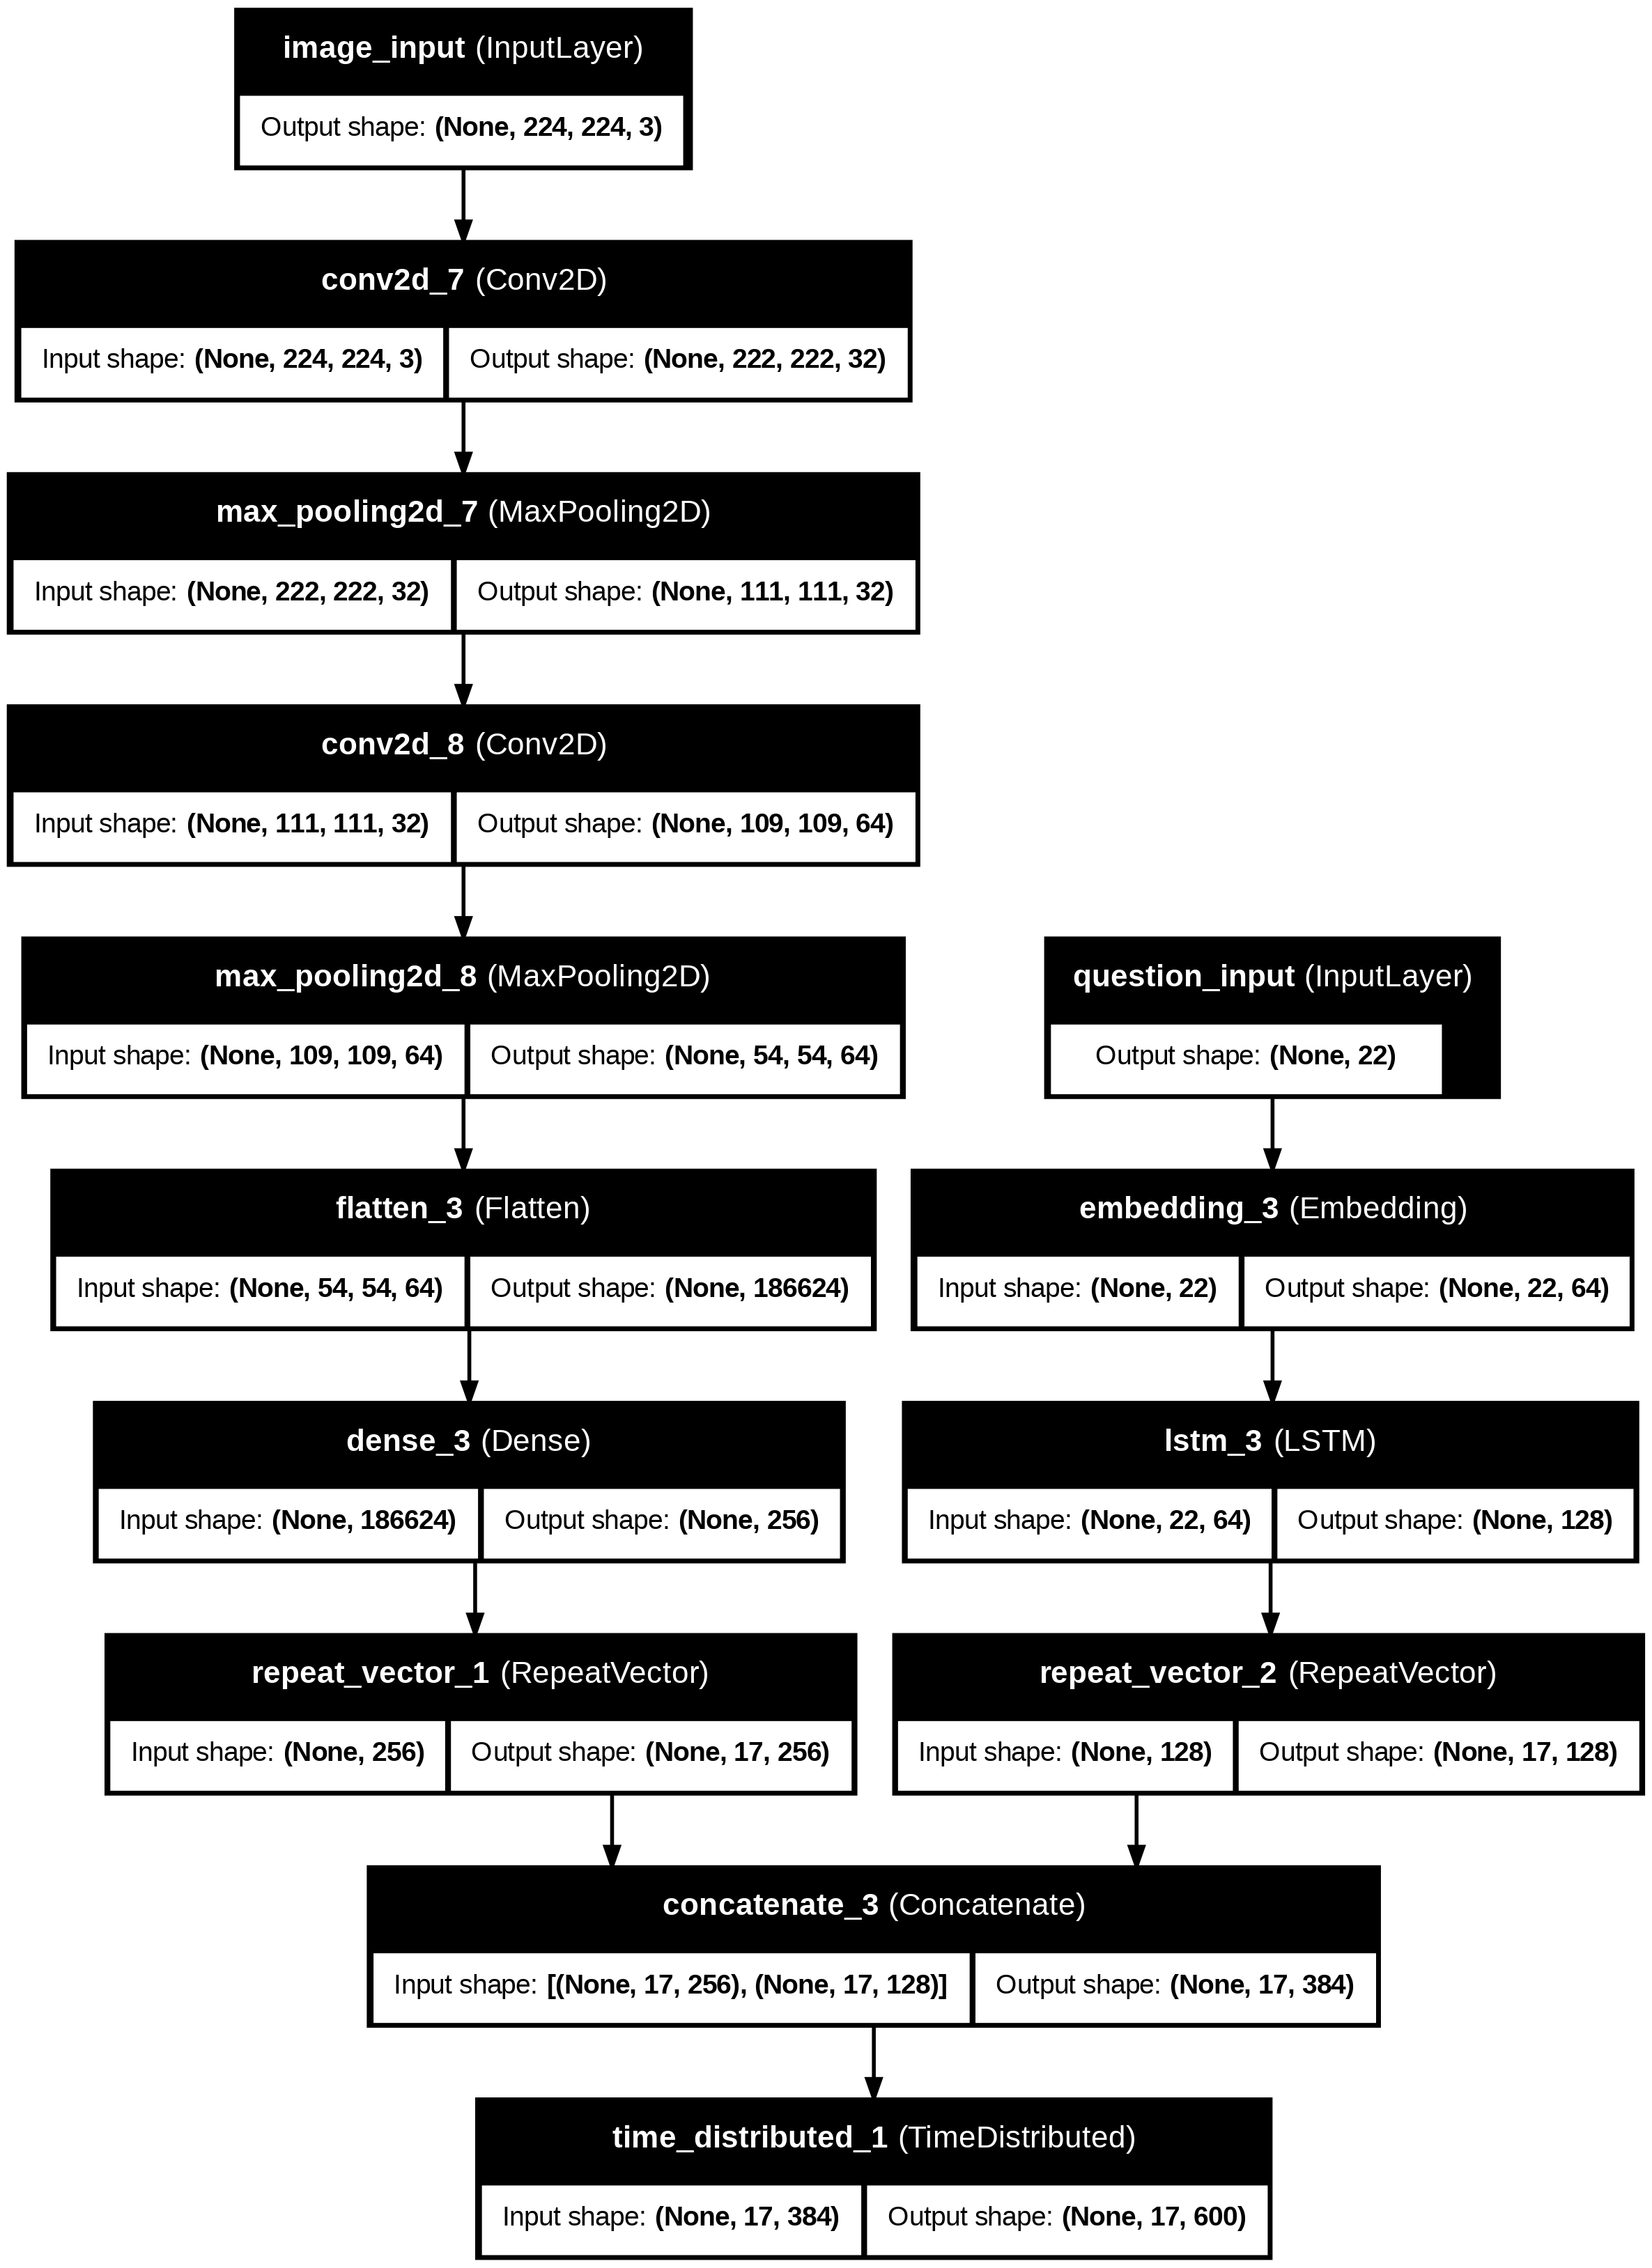

In [ ]:
plot_model(
    model_2_open,
    to_file='model_2_open_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_2_open")



history = model_2_open.fit(
    [X_img_train_o, X_q_train_o],   # training inputs
    y_train_o,                                 # labels
    validation_data=([X_img_test_o, X_q_test_o], y_test_o),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7196 - loss: 4.3581
Epoch 1: val_accuracy improved from -inf to 0.84768, saving model to model_2_open.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.7278 - loss: 4.2349 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 2/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 2: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 3/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8516 - loss: 2.3927
Epoch 3: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 4: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 5/100
23/24 ━━━━━━━━━━

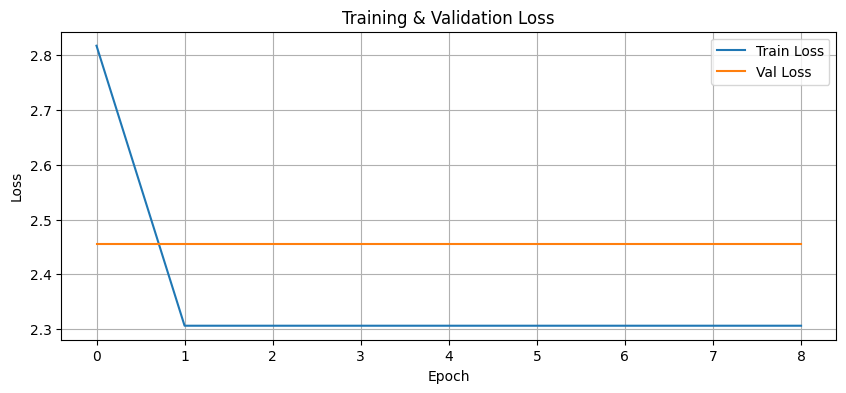

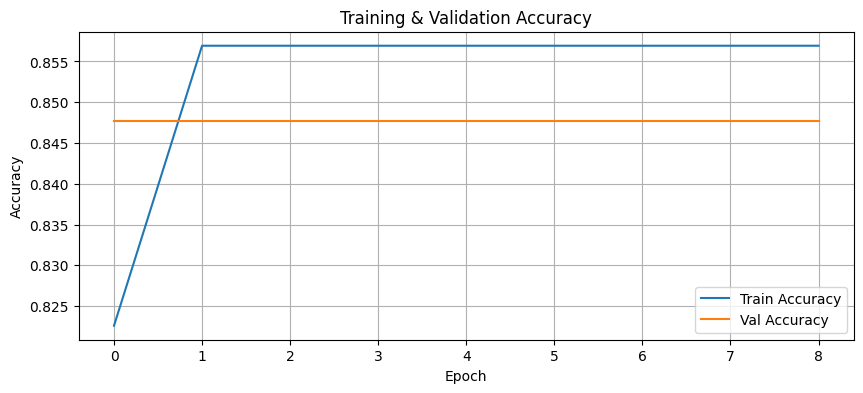

In [ ]:
# Load the CSV log
log = pd.read_csv('model_2_open.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#MODEL 3

##model 3 closed

In [ ]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Embedding, LSTM, Concatenate,
    Dropout, BatchNormalization
)
from tensorflow.keras.models import Model

# ---------------- Image branch ----------------
img_input_c = Input(shape=(224, 224, 3), name='image_input')

x = Conv2D(32, (3,3), padding='same', activation='relu',kernel_initializer=kernel_init)(img_input_c)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu',kernel_initializer=kernel_init)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer=kernel_init)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer=kernel_init)(x)   # 🔑 feature compression
x = Dropout(0.5, seed = SEED)(x)

# ---------------- Question branch ----------------
q_input_c = Input(shape=(X_q_train_c.shape[1],), name='question_input')

q = Embedding(
    input_dim=len(tokenizer_q_closed.word_index) + 1,
    output_dim=128,
    embeddings_initializer=embedding_init
)(q_input_c)

q = LSTM(128, return_sequences=False, kernel_initializer=kernel_init,recurrent_initializer=recurrent_init)(q)
q = Dropout(0.3,seed=SEED)(q)

# ---------------- Fusion ----------------
combined = Concatenate()([x, q])

combined = Dense(256, activation='relu',kernel_initializer=kernel_init)(combined)
combined = Dropout(0.4, seed=SEED)(combined)

combined = Dense(128, activation='relu',kernel_initializer=kernel_init)(combined)

# ---------------- Output ----------------
out_c = Dense(y_train_c.shape[1], activation='softmax',kernel_initializer=kernel_init)(combined)

# ---------------- Model ----------------
model_3_closed = Model(
    inputs=[img_input_c, q_input_c],
    outputs=out_c
)

model_3_closed.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3_closed.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 100352)    │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 21, 128)   │    112,256 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │ 51,380,736 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │    131,584 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 640)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 51,924,613 (198.08 MB)

 Trainable params: 51,924,165 (198.07 MB)

 Non-trainable params: 448 (1.75 KB)

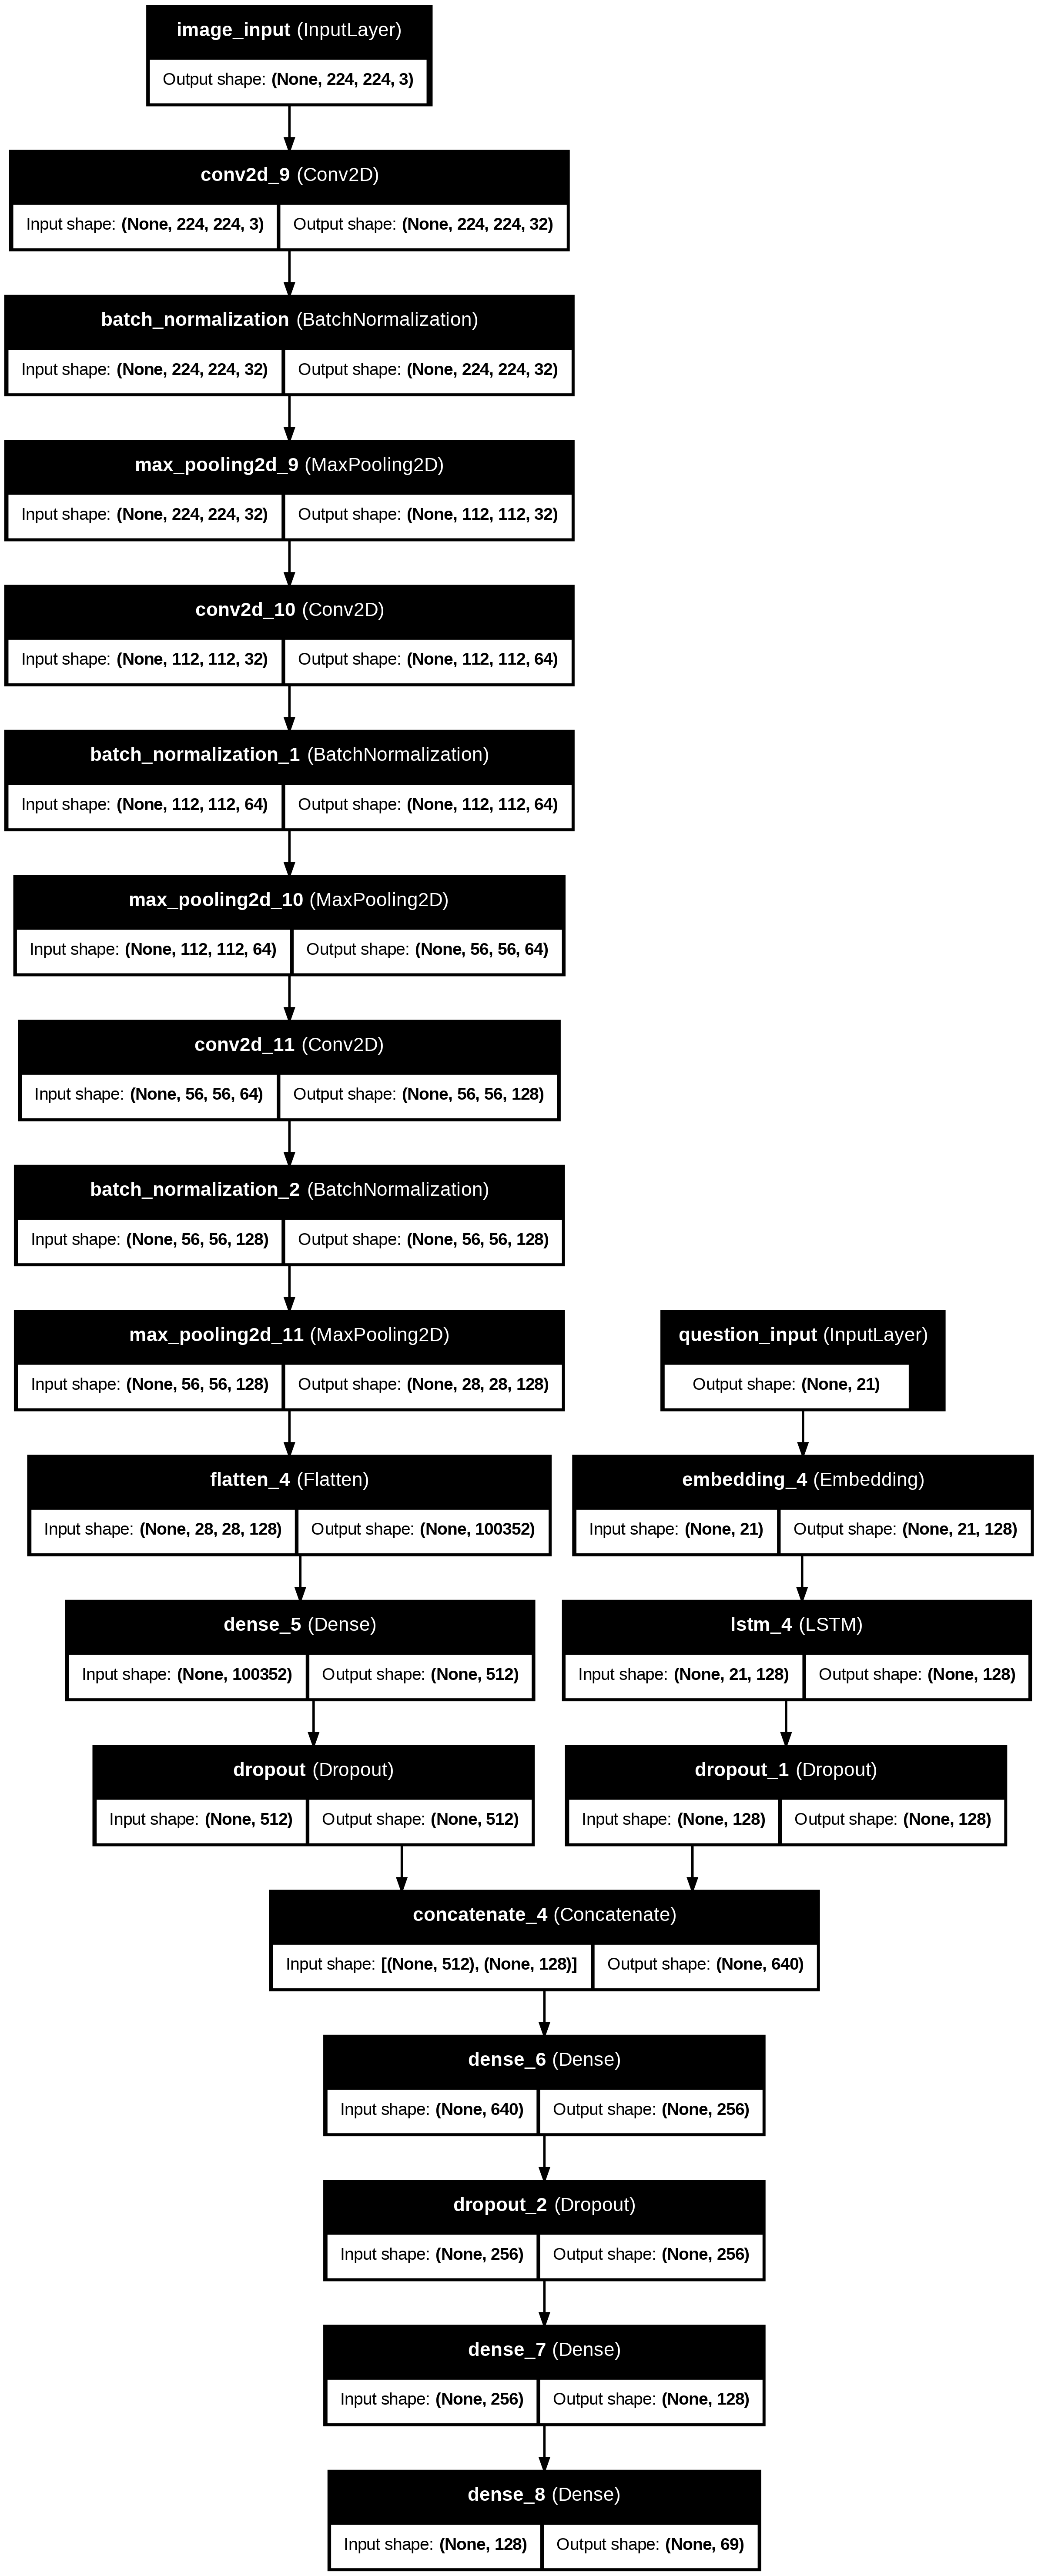

In [ ]:
plot_model(
    model_3_closed,
    to_file='model_3_closed_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_3_closed")

history = model_3_closed.fit(
    [X_img_train_c, X_q_train_c],   # training inputs
    y_train_c,                                 # labels
    validation_data=([X_img_test_c, X_q_test_c], y_test_c),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3427 - loss: 19.6191
Epoch 1: val_accuracy improved from -inf to 0.46923, saving model to model_3_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.3440 - loss: 19.5406 - val_accuracy: 0.4692 - val_loss: 36.4740 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4536 - loss: 8.8529
Epoch 2: val_accuracy did not improve from 0.46923
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4530 - loss: 8.8392 - val_accuracy: 0.4692 - val_loss: 6.4533 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4401 - loss: 6.7026
Epoch 3: val_accuracy did not improve from 0.46923
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4399 - loss: 6.6790 - val_accuracy: 0.4654 - val_loss: 3.9843 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4300 - loss: 4.5213
Epoch 4: val_accuracy improved from 0.46923 to 0.47692, saving model to model_3_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.4300 - loss: 4.5079 - val_accuracy: 0.4769 - val_loss: 2.1379 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5064 - loss: 2.7090
Epoch 5: val_accuracy improved from 0.47692 to 0.48846, saving model to model_3_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5059 - loss: 2.7042 - val_accuracy: 0.4885 - val_loss: 1.8669 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4625 - loss: 2.6765
Epoch 6: val_accuracy did not improve from 0.48846
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4627 - loss: 2.6756 - val_accuracy: 0.4885 - val_loss: 1.6275 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5071 - loss: 2.2767
Epoch 7: val_accuracy did not improve from 0.48846
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5069 - loss: 2.2737 - val_accuracy: 0.4846 - val_loss: 1.3993 - learning_rate: 0.0010
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4673 - loss: 1.9309
Epoch 8: val_accuracy did not improve from 0.48846
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4672 - loss: 1.9274 - val_accuracy: 0.4692 - val_loss: 1.2747 - learning_rate: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━

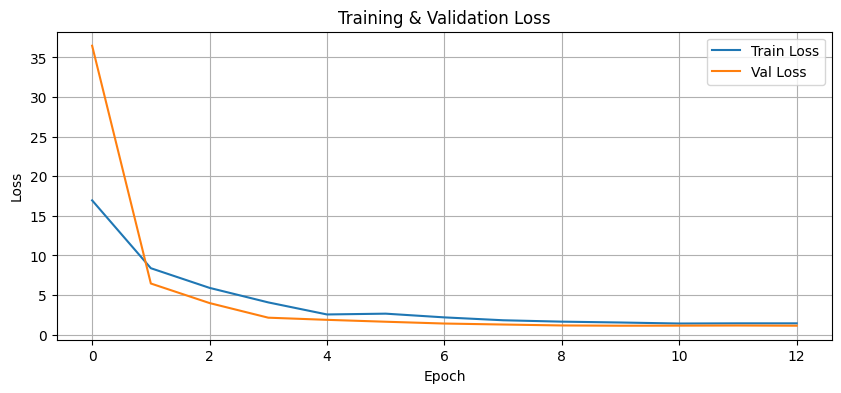

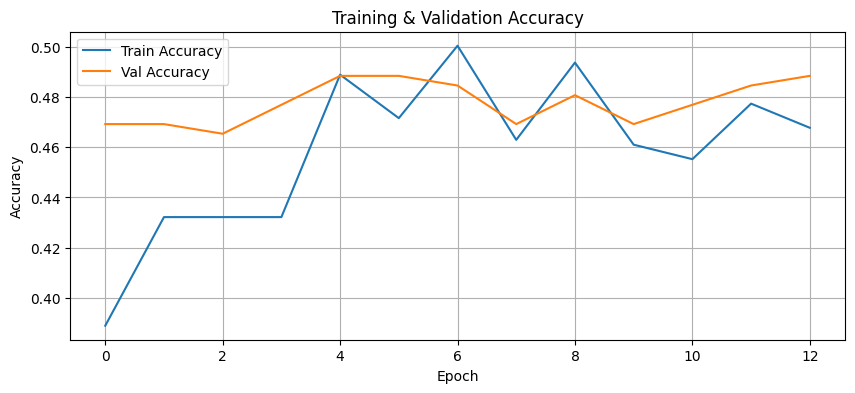

In [ ]:
# Load the CSV log
log = pd.read_csv('model_3_closed.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##model 3 open

In [ ]:
# ---------------- Image branch ----------------
img_input_o = Input(shape=(224, 224, 3), name='image_input')

x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(img_input_o)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer=kernel_init)(x)
x = Dropout(0.5, seed=SEED)(x)

# Repeat image features for each answer token
x = RepeatVector(y_train_o.shape[1])(x)

# ---------------- Question branch ----------------
q_input_o = Input(shape=(X_q_train_o.shape[1],), name='question_input')

q = Embedding(
    input_dim=len(tokenizer_q_open.word_index) + 1,
    output_dim=128,
    embeddings_initializer=embedding_init
)(q_input_o)

q = LSTM(128, return_sequences=False, kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)
q = Dropout(0.3, seed=SEED)(q)

# Repeat question features
q = RepeatVector(y_train_o.shape[1])(q)

# ---------------- Combine ----------------
combined_o = Concatenate(axis=-1)([x, q])

# 🔑 Fusion layers (new, but structure-safe)
combined_o = TimeDistributed(Dense(256, activation='relu', kernel_initializer=kernel_init))(combined_o)
combined_o = TimeDistributed(Dropout(0.4, seed=SEED))(combined_o)

combined_o = TimeDistributed(Dense(128, activation='relu', kernel_initializer=kernel_init))(combined_o)

# ---------------- Output ----------------
vocab_size = len(tokenizer_a_open.word_index) + 1

out_o = TimeDistributed(
    Dense(vocab_size, activation='softmax', kernel_initializer=kernel_init)
)(combined_o)
# ---------------- Model ----------------
model_3_open = Model(
    inputs=[img_input_o, q_input_o],
    outputs=out_o
)

model_3_open.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_3_open.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 100352)    │          0 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 22, 128)   │     90,496 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │ 51,380,736 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    131,584 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 17, 512)   │          0 │ dropout_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 51,971,352 (198.25 MB)

 Trainable params: 51,970,904 (198.25 MB)

 Non-trainable params: 448 (1.75 KB)

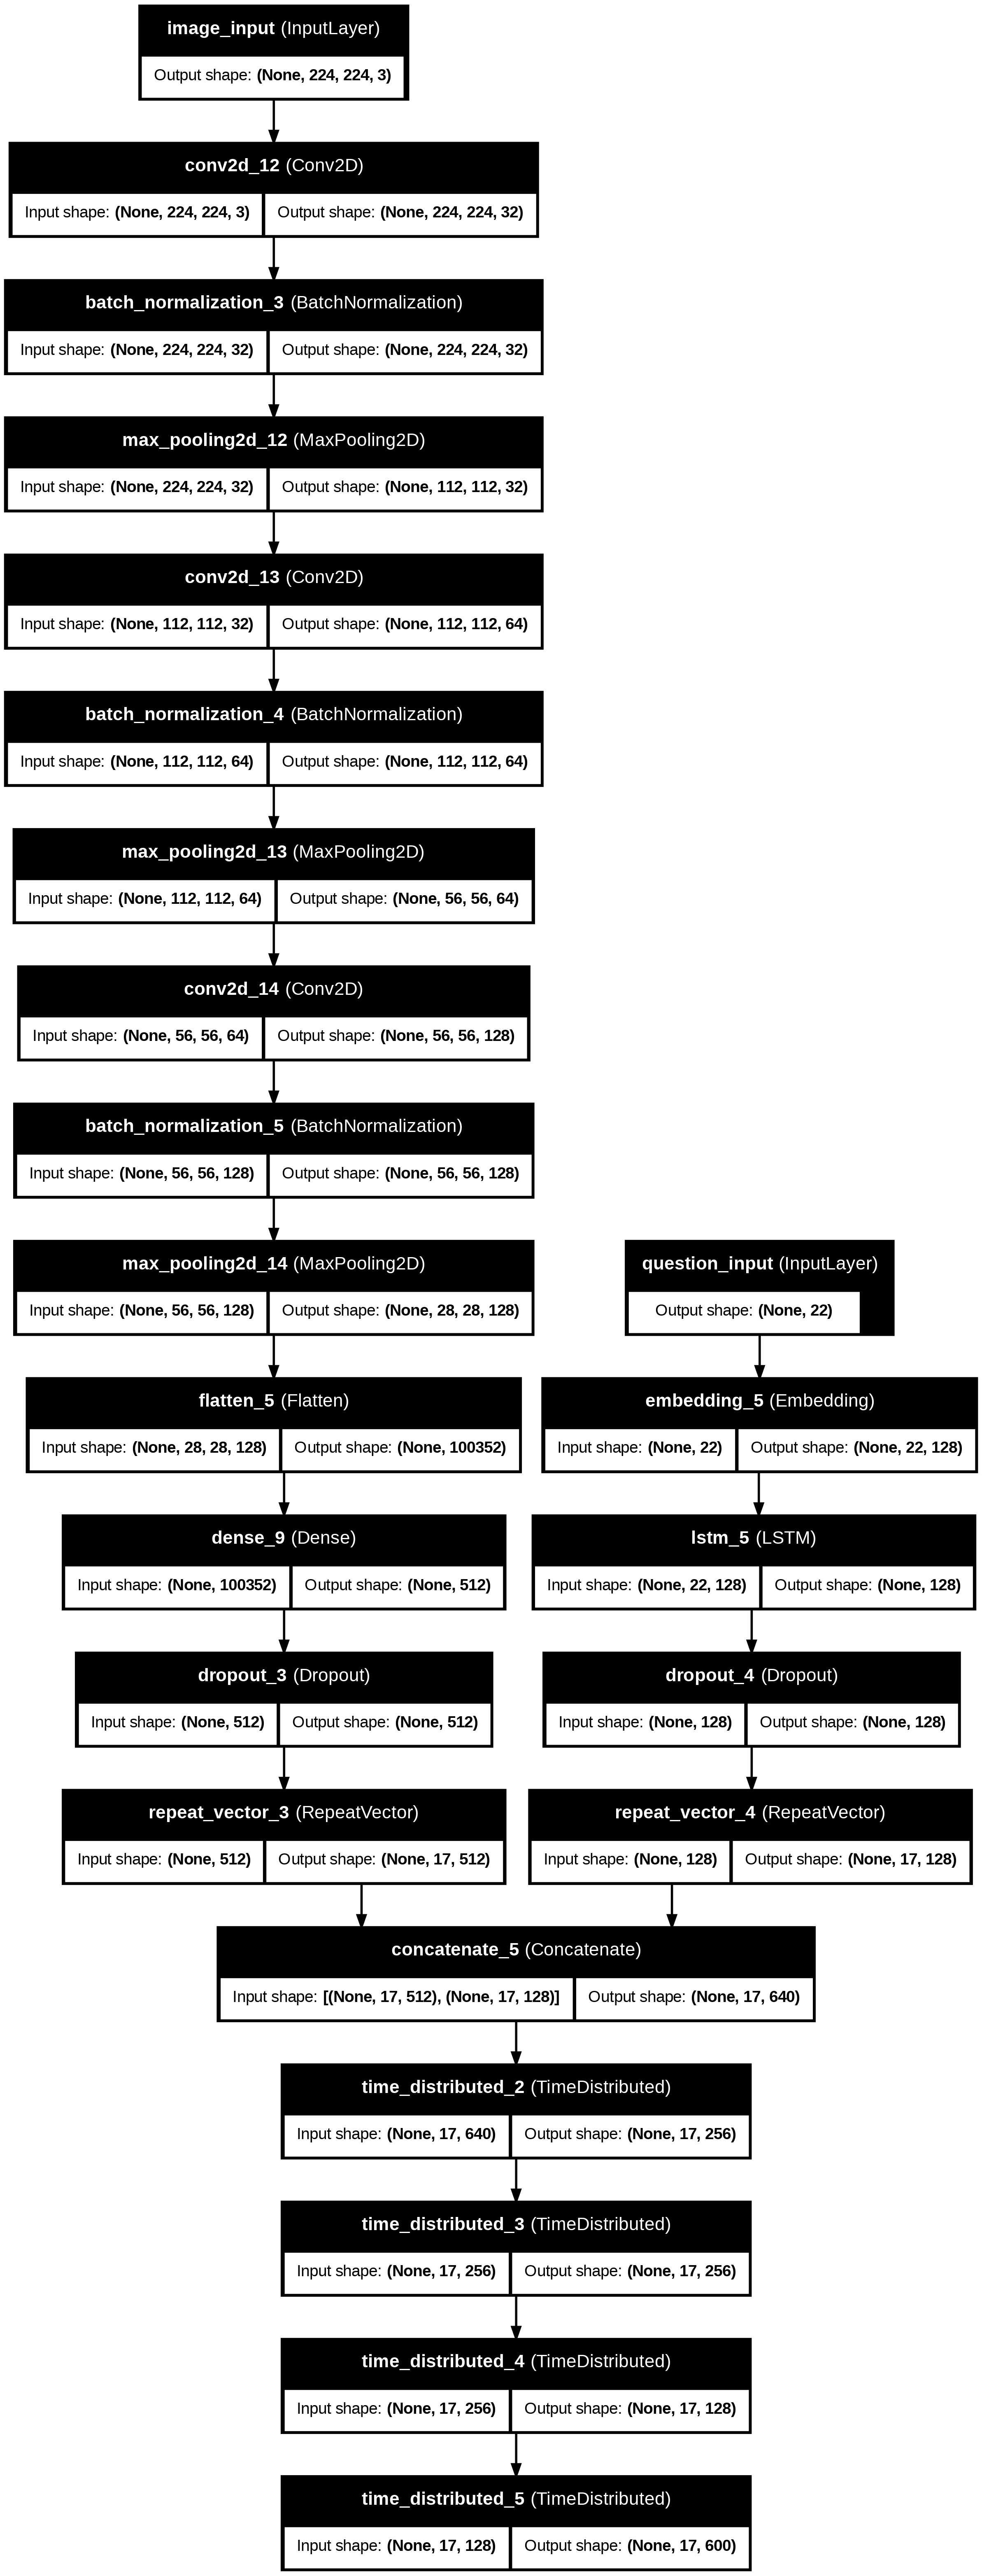

In [ ]:
plot_model(
    model_3_open,
    to_file='model_3_open_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_3_open")



history = model_3_open.fit(
    [X_img_train_o, X_q_train_o],   # training inputs
    y_train_o,                                 # labels
    validation_data=([X_img_test_o, X_q_test_o], y_test_o),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6528 - loss: 3.5686
Epoch 1: val_accuracy improved from -inf to 0.84768, saving model to model_3_open.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.6586 - loss: 3.5325 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 2/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 2: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8520 - loss: 2.3850
Epoch 3: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 4: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 5/100
23/24 ━━━━━━━━━

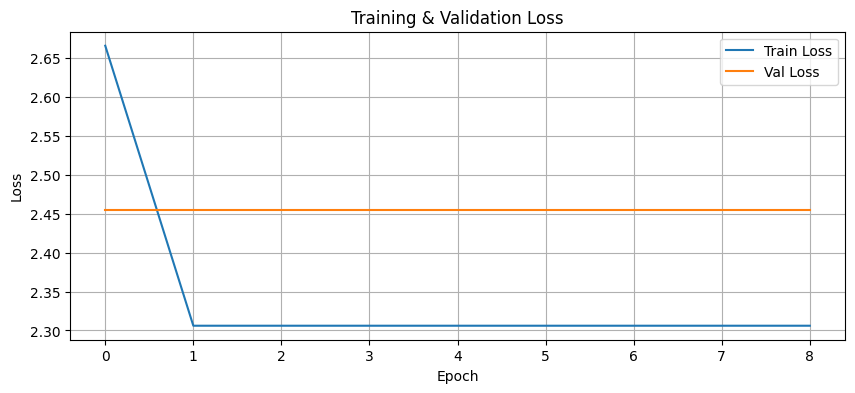

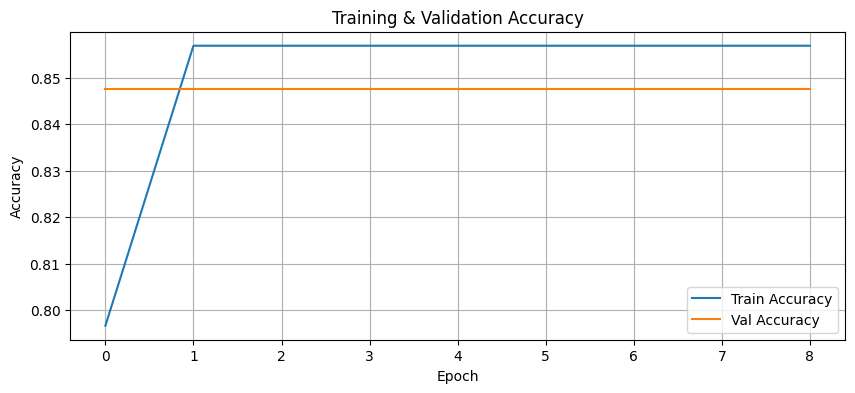

In [ ]:
# Load the CSV log
log = pd.read_csv('model_3_open.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Model 4

## model 4 closed

In [ ]:
# ---------------- Image branch ----------------
img_input_c = Input(shape=(224, 224, 3), name='image_input')

x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(img_input_c)
x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)

# Image reasoning layers (same philosophy as model_2_open)
x = Dense(512, activation='relu', kernel_initializer=kernel_init)(x)
x = Dropout(0.5,seed=SEED)(x)

x = Dense(256, activation='relu', kernel_initializer=kernel_init)(x)
x = Dropout(0.4,seed=SEED)(x)

# ---------------- Question branch ----------------
q_input_c = Input(shape=(X_q_train_c.shape[1],), name='question_input')

q = Embedding(
    input_dim=len(tokenizer_q_closed.word_index) + 1,
    output_dim=128,
    embeddings_initializer=embedding_init
)(q_input_c)

q = LSTM(128, return_sequences=False, kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)
q = Dropout(0.3, seed=SEED)(q)

q = Dense(128, activation='relu', kernel_initializer=kernel_init)(q)   # extra reasoning layer
q = Dropout(0.3, seed=SEED)(q)

# ---------------- Fusion ----------------
combined = Concatenate()([x, q])

combined = Dense(512, activation='relu', kernel_initializer=kernel_init)(combined)
combined = Dropout(0.4, seed=SEED)(combined)

combined = Dense(256, activation='relu', kernel_initializer=kernel_init)(combined)
combined = Dropout(0.3, seed=SEED)(combined)

combined = Dense(128, activation='relu', kernel_initializer=kernel_init)(combined)

# ---------------- Output ----------------
out_c = Dense(y_train_c.shape[1], activation='softmax',kernel_initializer=kernel_init)(combined)

# ---------------- Model ----------------
model_4_closed = Model(
    inputs=[img_input_c, q_input_c],
    outputs=out_c
)

model_4_closed.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_4_closed.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │      9,248 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 56, 56,    │    147,584 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 28, 28,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 100352)    │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 21, 128)   │    112,256 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │ 51,380,736 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 128)       │    131,584 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     16,512 │ dropout_8[0][0] 

 Total params: 52,429,669 (200.00 MB)

 Trainable params: 52,429,669 (200.00 MB)

 Non-trainable params: 0 (0.00 B)

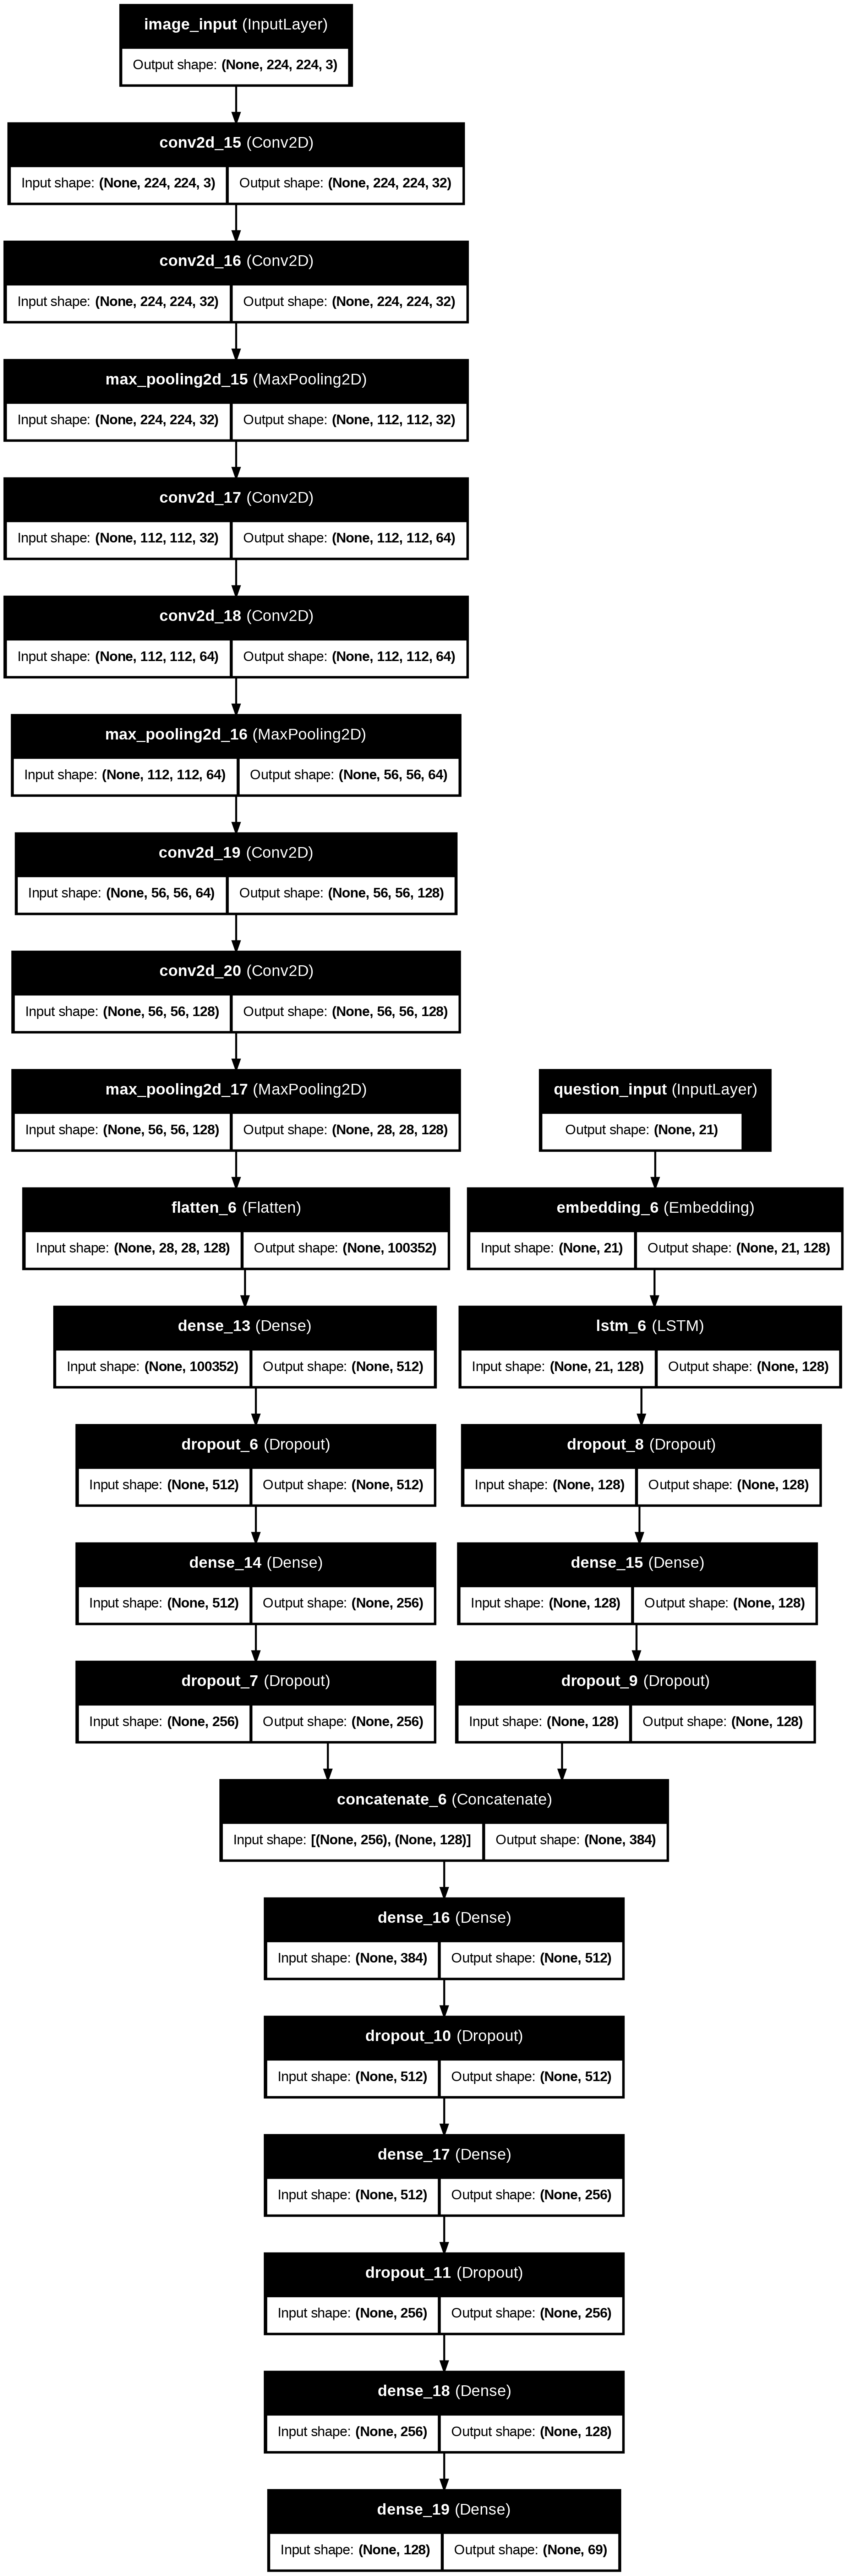

In [ ]:
plot_model(
    model_4_closed,
    to_file='model_4_closed_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_4_closed")

history = model_4_closed.fit(
    [X_img_train_c, X_q_train_c],   # training inputs
    y_train_c,                                 # labels
    validation_data=([X_img_test_c, X_q_test_c], y_test_c),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3991 - loss: 8.5518
Epoch 1: val_accuracy improved from -inf to 0.46538, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.4004 - loss: 8.4191 - val_accuracy: 0.4654 - val_loss: 1.1720 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4295 - loss: 1.4308
Epoch 2: val_accuracy did not improve from 0.46538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4301 - loss: 1.4271 - val_accuracy: 0.4654 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4497 - loss: 1.1574
Epoch 3: val_accuracy did not improve from 0.46538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4499 - loss: 1.1567 - val_accuracy: 0.4615 - val_loss: 0.8839 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4729 - loss: 1.0807
Epoch 4: val_accuracy did not improve from 0.46538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4725 - loss: 1.0810 - val_accuracy: 0.4615 - val_loss: 0.8955 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.4175 - loss: 1.0893 - val_accuracy: 0.4769 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4584 - loss: 1.0709
Epoch 7: val_accuracy did not improve from 0.47692
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4593 - loss: 1.0702 - val_accuracy: 0.4769 - val_loss: 0.8906 - learning_rate: 0.0010
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5311 - loss: 1.0324
Epoch 8: val_accuracy improved from 0.47692 to 0.50385, saving model to model_4_closed.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.5315 - loss: 1.0321 - val_accuracy: 0.5038 - val_loss: 0.9393 - learning_rate: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5577 - loss: 1.0053
Epoch 9: val_accuracy improved from 0.50385 to 0.55385, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5584 - loss: 1.0048 - val_accuracy: 0.5538 - val_loss: 0.8866 - learning_rate: 5.0000e-04
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6187 - loss: 0.9511
Epoch 10: val_accuracy improved from 0.55385 to 0.56538, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6190 - loss: 0.9505 - val_accuracy: 0.5654 - val_loss: 0.9045 - learning_rate: 5.0000e-04
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6585 - loss: 0.9196
Epoch 11: val_accuracy improved from 0.56538 to 0.64231, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6590 - loss: 0.9192 - val_accuracy: 0.6423 - val_loss: 0.8775 - learning_rate: 5.0000e-04
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6377 - loss: 0.9103
Epoch 12: val_accuracy did not improve from 0.64231
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6385 - loss: 0.9094 - val_accuracy: 0.6231 - val_loss: 0.9318 - learning_rate: 5.0000e-04
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6473 - loss: 0.8867
Epoch 13: val_accuracy improved from 0.64231 to 0.65000, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6483 - loss: 0.8853 - val_accuracy: 0.6500 - val_loss: 0.9639 - learning_rate: 5.0000e-04
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6928 - loss: 0.8504
Epoch 14: val_accuracy improved from 0.65000 to 0.66154, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6936 - loss: 0.8494 - val_accuracy: 0.6615 - val_loss: 0.9479 - learning_rate: 5.0000e-04
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7479 - loss: 0.8044
Epoch 15: val_accuracy did not improve from 0.66154
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7485 - loss: 0.8030 - val_accuracy: 0.6615 - val_loss: 1.0843 - learning_rate: 5.0000e-04
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7326 - loss: 0.7691
Epoch 16: val_accuracy did not improve from 0.66154

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7327 - loss: 0.7690 - val_accuracy: 0.6385 - val_loss: 1.1690 - learning_rate: 5.0000e-04
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7724 - loss: 0.6994
Epoch 17: val_accuracy improved from 0.66154 to 0.68846, saving model to model_4_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.7727 - loss: 0.6985 - val_accuracy: 0.6885 - val_loss: 1.0266 - learning_rate: 2.5000e-04
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8132 - loss: 0.6375
Epoch 18: val_accuracy did not improve from 0.68846
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8135 - loss: 0.6365 - val_accuracy: 0.6654 - val_loss: 1.1420 - learning_rate: 2.5000e-04
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8265 - loss: 0.5649
Epoch 19: val_accuracy did not improve from 0.68846
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8266 - loss: 0.5651 - val_accuracy: 0.6731 - val_loss: 1.2142 - learning_rate: 2.5000e-04
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8296 - loss: 0.5776
Epoch 20: val_accuracy did not improve from 0.68846
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8295 - loss: 0.5777 - val_accuracy: 0.6654 - val_loss: 1.2124 - learning_rate: 2.5000e-04
Epoch 

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8662 - loss: 0.4804 - val_accuracy: 0.6962 - val_loss: 1.3991 - learning_rate: 1.2500e-04
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8620 - loss: 0.4837
Epoch 25: val_accuracy did not improve from 0.69615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8621 - loss: 0.4838 - val_accuracy: 0.6962 - val_loss: 1.3940 - learning_rate: 1.2500e-04
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8717 - loss: 0.4763
Epoch 26: val_accuracy did not improve from 0.69615

Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8714 - loss: 0.4768 - val_accuracy: 0.6923 - val_loss: 1.4249 - learning_rate: 1.2500e-04
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8830 - loss: 0.4392
Epoch 27: val_accuracy did not improve from 0.69615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8831 - loss: 0.4392 

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8853 - loss: 0.4410 - val_accuracy: 0.7077 - val_loss: 1.5299 - learning_rate: 6.2500e-05
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8855 - loss: 0.4431
Epoch 31: val_accuracy did not improve from 0.70769

Epoch 31: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8854 - loss: 0.4432 - val_accuracy: 0.7038 - val_loss: 1.5752 - learning_rate: 6.2500e-05
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8834 - loss: 0.4470
Epoch 32: val_accuracy did not improve from 0.70769
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8835 - loss: 0.4469 - val_accuracy: 0.6962 - val_loss: 1.6275 - learning_rate: 3.1250e-05
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8835 - loss: 0.4389
Epoch 33: val_accuracy did not improve from 0.70769
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8835 - loss: 0.4390

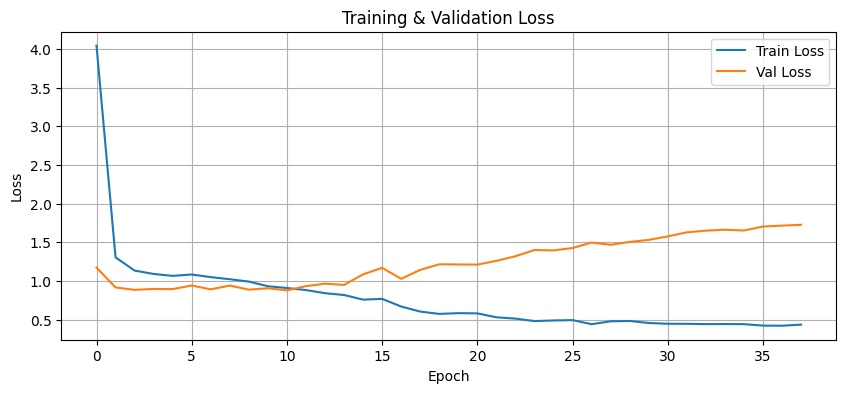

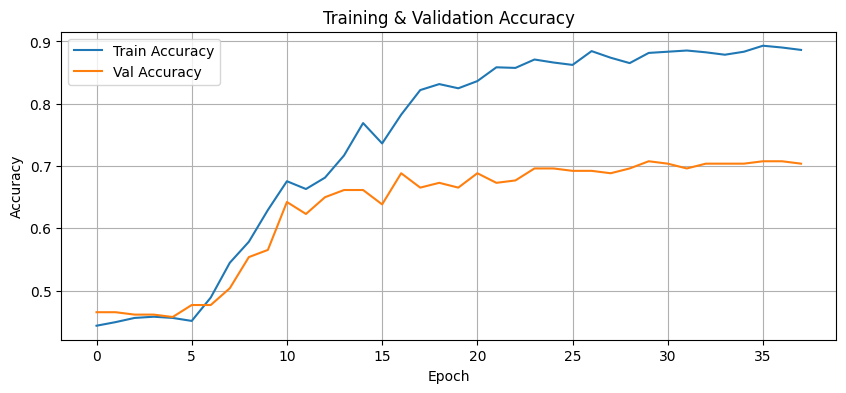

In [ ]:
# Load the CSV log
log = pd.read_csv('model_4_closed.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##model 4 open

In [ ]:
# ---------------- Image branch ----------------
img_input_o = Input(shape=(224, 224, 3), name='image_input')

x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(img_input_o)
x = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)

# Dense stack (image reasoning)
x = Dense(512, activation='relu', kernel_initializer=kernel_init)(x)
x = Dropout(0.5,seed=SEED)(x)

x = Dense(256, activation='relu', kernel_initializer=kernel_init)(x)
x = Dropout(0.4,seed=SEED)(x)

# Repeat image features
x = RepeatVector(y_train_o.shape[1])(x)

# ---------------- Question branch ----------------
q_input_o = Input(shape=(X_q_train_o.shape[1],), name='question_input')

q = Embedding(
    input_dim=len(tokenizer_q_open.word_index) + 1,
    output_dim=128,
    embeddings_initializer=embedding_init
)(q_input_o)

q = LSTM(128, return_sequences=False, kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)
q = Dropout(0.3,seed=SEED)(q)

q = Dense(128, activation='relu', kernel_initializer=kernel_init)(q)  # extra reasoning
q = Dropout(0.3,seed=SEED)(q)

# Repeat question features
q = RepeatVector(y_train_o.shape[1])(q)

# ---------------- Combine ----------------
combined_o = Concatenate(axis=-1)([x, q])

# 🔑 Deep fusion layers (token-wise reasoning)
combined_o = TimeDistributed(Dense(512, activation='relu', kernel_initializer=kernel_init))(combined_o)
combined_o = TimeDistributed(Dropout(0.4, seed=SEED))(combined_o)

combined_o = TimeDistributed(Dense(256, activation='relu', kernel_initializer=kernel_init))(combined_o)
combined_o = TimeDistributed(Dropout(0.3, seed=SEED))(combined_o)

combined_o = TimeDistributed(Dense(128, activation='relu', kernel_initializer=kernel_init))(combined_o)

# ---------------- Output ----------------
vocab_size = len(tokenizer_a_open.word_index) + 1
out_o = TimeDistributed(
    Dense(vocab_size, activation='softmax', kernel_initializer=kernel_init)
)(combined_o)

# ---------------- Model ----------------
model_4_open = Model(
    inputs=[img_input_o, q_input_o],
    outputs=out_o
)

model_4_open.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_4_open.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 224, 224,  │      9,248 │ conv2d_21[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 112, 112,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 112, 112,  │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 56, 56,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 56, 56,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 28, 28,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 100352)    │          0 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 22, 128)   │     90,496 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │ 51,380,736 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 128)       │    131,584 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 512)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    131,328 │ dropout_12[0][0]

 Total params: 52,476,408 (200.18 MB)

 Trainable params: 52,476,408 (200.18 MB)

 Non-trainable params: 0 (0.00 B)

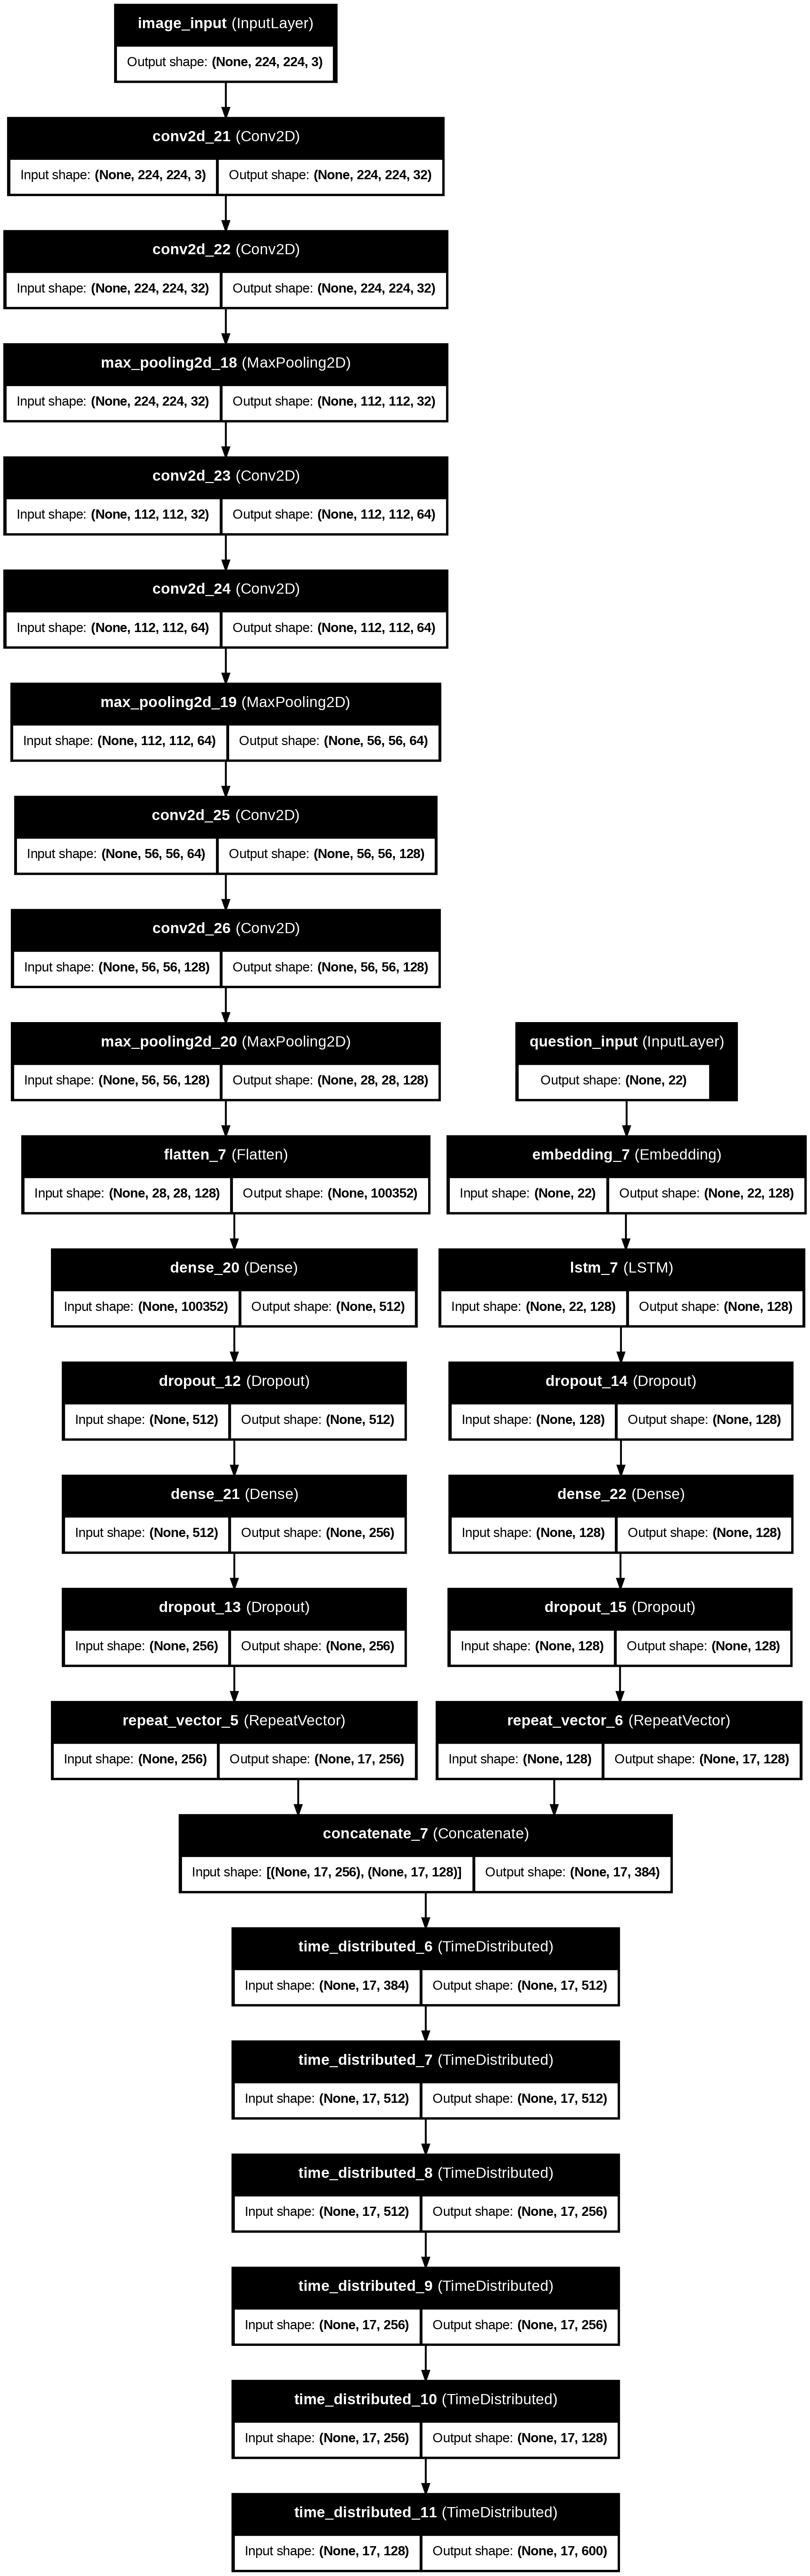

In [ ]:
plot_model(
    model_4_open,
    to_file='model_3_open_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_4_open")



history = model_4_open.fit(
    [X_img_train_o, X_q_train_o],   # training inputs
    y_train_o,                                 # labels
    validation_data=([X_img_test_o, X_q_test_o], y_test_o),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6190 - loss: 5.2652
Epoch 1: val_accuracy improved from -inf to 0.84768, saving model to model_4_open.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.6256 - loss: 5.1822 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 2/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 2: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 3/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 3: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 4: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 5/100
23/24 ━━━━━━━━━

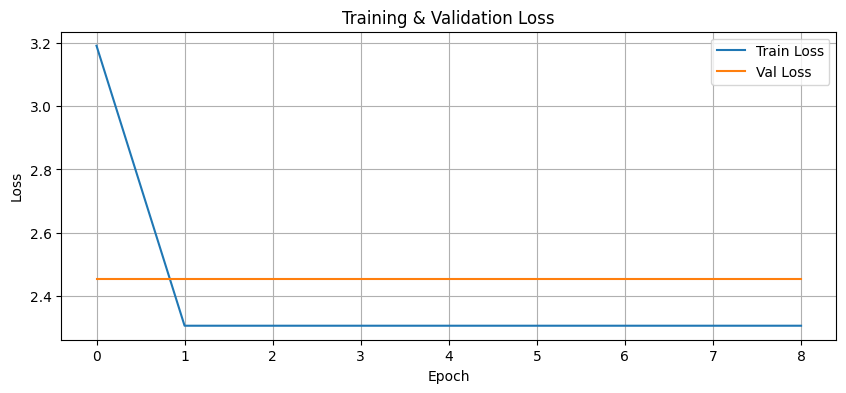

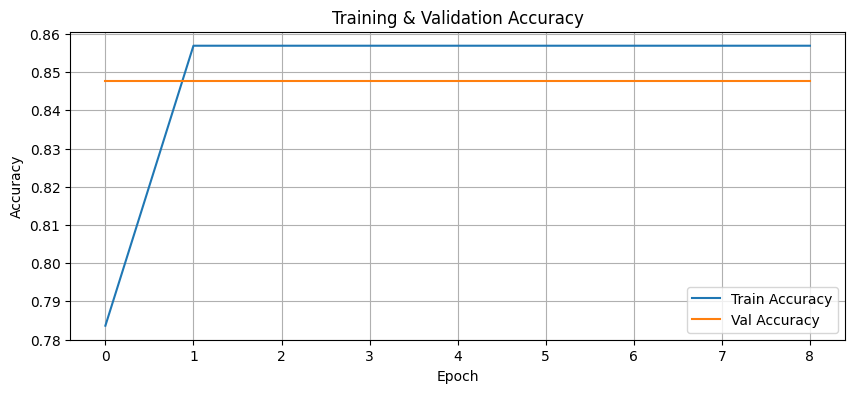

In [ ]:
# Load the CSV log
log = pd.read_csv('model_4_open.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Model 5

##Model 5 closed

In [ ]:
# ---------------- Image branch ----------------
img_input_c = Input(shape=(224, 224, 3), name='image_input')

x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=kernel_init)(img_input_c)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)

# ---------------- Question branch ----------------
q_input_c = Input(shape=(X_q_train_c.shape[1],), name='question_input')

q = Embedding(
    input_dim=len(tokenizer_q_closed.word_index) + 1,
    output_dim=64,
    mask_zero=True,
    embeddings_initializer=embedding_init
)(q_input_c)

q = LSTM(64, return_sequences=True,kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)

q = LSTM(64,kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)

# ---------------- Fusion ----------------
combined = Concatenate()([x, q])

# ---------------- Output ----------------
out_c = Dense(y_train_c.shape[1], activation='softmax', kernel_initializer=kernel_init)(combined)

# ---------------- Model ----------------
model_5_closed = Model(
    inputs=[img_input_c, q_input_c],
    outputs=out_c
)

model_5_closed.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_5_closed.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 112, 112,  │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 56, 56,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_22… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 28, 28,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │    295,168 │ max_pooling2d_23… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 21, 64)    │     56,128 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 21)        │          0 │ question_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 14, 14,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 21, 64)    │     33,024 │ embedding_8[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 50176)     │          0 │ max_pooling2d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     33,024 │ lstm_8[0][0],     │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 50240)     │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 69)        │  3,466,629 │ concatenate_8[0]… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 3,977,221 (15.17 MB)

 Trainable params: 3,977,221 (15.17 MB)

 Non-trainable params: 0 (0.00 B)

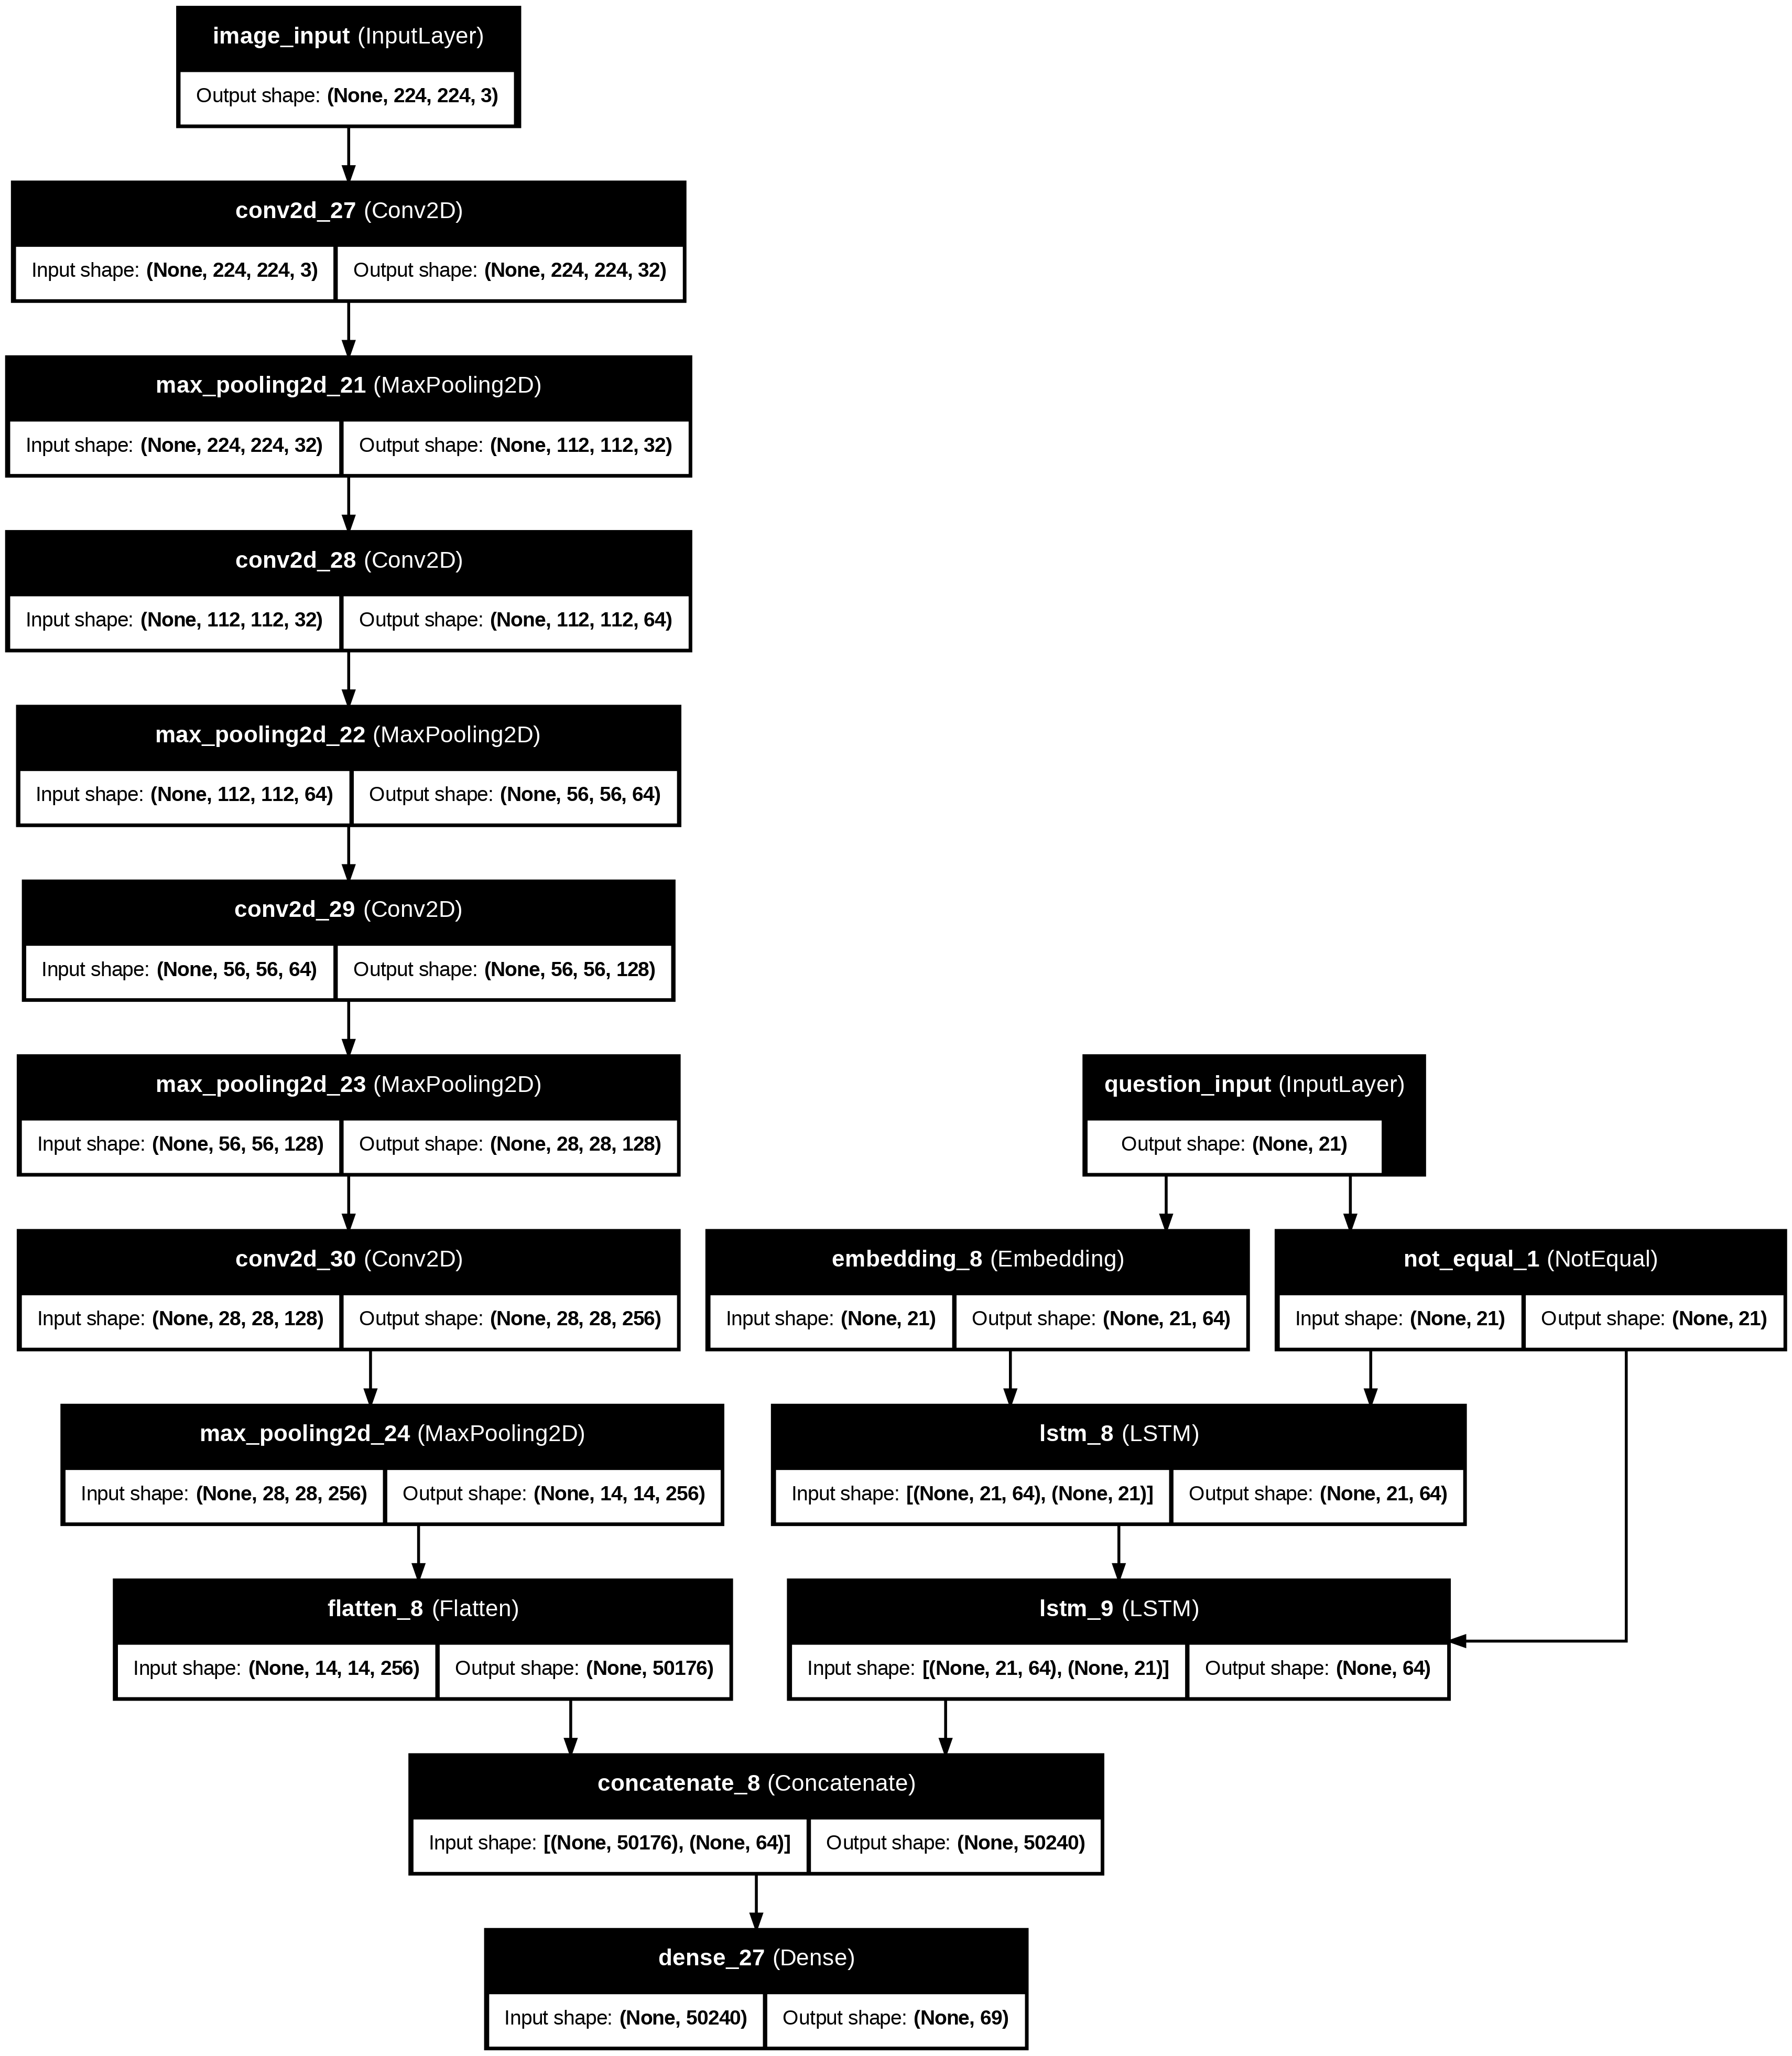

In [ ]:
plot_model(
    model_5_closed,
    to_file='model_5_closed_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_5_closed")

history = model_5_closed.fit(
    [X_img_train_c, X_q_train_c],   # training inputs
    y_train_c,                                 # labels
    validation_data=([X_img_test_c, X_q_test_c], y_test_c),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3955 - loss: 32.4894
Epoch 1: val_accuracy improved from -inf to 0.48462, saving model to model_5_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3974 - loss: 31.9305 - val_accuracy: 0.4846 - val_loss: 1.3115 - learning_rate: 0.0010
Epoch 2/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5170 - loss: 1.3019
Epoch 2: val_accuracy improved from 0.48462 to 0.62692, saving model to model_5_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5205 - loss: 1.2952 - val_accuracy: 0.6269 - val_loss: 1.1785 - learning_rate: 0.0010
Epoch 3/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6084 - loss: 0.9200
Epoch 3: val_accuracy improved from 0.62692 to 0.64615, saving model to model_5_closed.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6128 - loss: 0.9122 - val_accuracy: 0.6462 - val_loss: 1.2826 - learning_rate: 0.0010
Epoch 4/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6954 - loss: 0.7006
Epoch 4: val_accuracy did not improve from 0.64615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6997 - loss: 0.6959 - val_accuracy: 0.6038 - val_loss: 1.4550 - learning_rate: 0.0010
Epoch 5/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7448 - loss: 0.5584
Epoch 5: val_accuracy did not improve from 0.64615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7483 - loss: 0.5545 - val_accuracy: 0.6423 - val_loss: 1.3342 - learning_rate: 0.0010
Epoch 6/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8281 - loss: 0.4130
Epoch 6: val_accuracy did not improve from 0.64615
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8290 - loss: 0.4104 - val_accuracy: 0.6346 - val_loss: 1.4196 - learning_rate: 0.0010
Epoch 7/100
31/33 ━━━━━━━━━━━


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8754 - loss: 0.3219 - val_accuracy: 0.6654 - val_loss: 1.5228 - learning_rate: 0.0010
Epoch 8/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8837 - loss: 0.2755
Epoch 8: val_accuracy did not improve from 0.66538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8853 - loss: 0.2723 - val_accuracy: 0.6654 - val_loss: 1.5726 - learning_rate: 5.0000e-04
Epoch 9/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9318 - loss: 0.1934
Epoch 9: val_accuracy did not improve from 0.66538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9322 - loss: 0.1921 - val_accuracy: 0.6577 - val_loss: 1.6997 - learning_rate: 5.0000e-04
Epoch 10/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9328 - loss: 0.1735
Epoch 10: val_accuracy did not improve from 0.66538
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9332 - loss: 0.1725 - val_ac

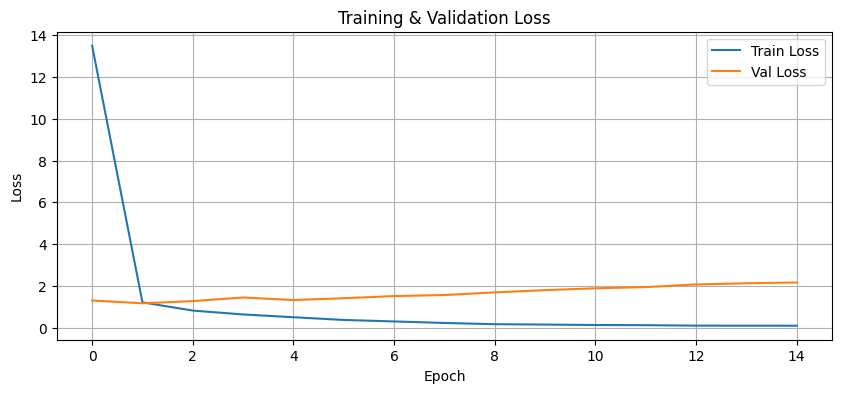

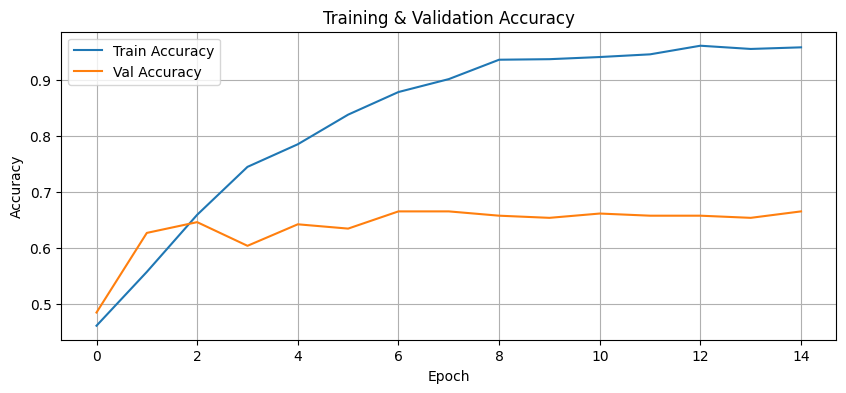

In [ ]:
# Load the CSV log
log = pd.read_csv('model_5_closed.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##model 5 open

In [ ]:
# ---- Image input branch ----
img_input_o = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3,3), activation='relu', kernel_initializer=kernel_init)(img_input_o)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=kernel_init)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer=kernel_init)(x)
x = RepeatVector(y_train_o.shape[1])(x)  # repeat for each answer token

# ---- Question input branch ----
q_input_o = Input(shape=(X_q_train_o.shape[1],), name='question_input')
q = Embedding(input_dim=len(tokenizer_q_open.word_index)+1, output_dim=128,embeddings_initializer=embedding_init)(q_input_o)
q = LSTM(64, return_sequences=True, kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)  # output 2D
q = LSTM(64, kernel_initializer=kernel_init,
    recurrent_initializer=recurrent_init)(q)  # output 2D
q = RepeatVector(y_train_o.shape[1])(q)   # repeat for each answer token

# ---- Combine image + question ----
combined_o = Concatenate(axis=-1)([x, q])
out_o = TimeDistributed(Dense(len(tokenizer_a_open.word_index)+1, activation='softmax',kernel_initializer=kernel_init))(combined_o)

# ---- Define model ----
model_5_open = Model(inputs=[img_input_o, q_input_o], outputs=out_o)
model_5_open.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_5_open.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 111, 111,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 54, 54,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 54, 54,    │     73,856 │ max_pooling2d_26… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 27, 27,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 22, 128)   │     90,496 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 93312)     │          0 │ max_pooling2d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 22, 64)    │     49,408 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │ 23,888,128 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 64)        │     33,024 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 17, 256)   │          0 │ dense_28[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 17, 64)    │          0 │ lstm_11[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 17, 320)   │          0 │ repeat_vector_7[… │
│ (Concatenate)       │                   │            │ repeat_vector_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 17, 600)   │    192,600 │ concatenate_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,346,904 (92.88 MB)

 Trainable params: 24,346,904 (92.88 MB)

 Non-trainable params: 0 (0.00 B)

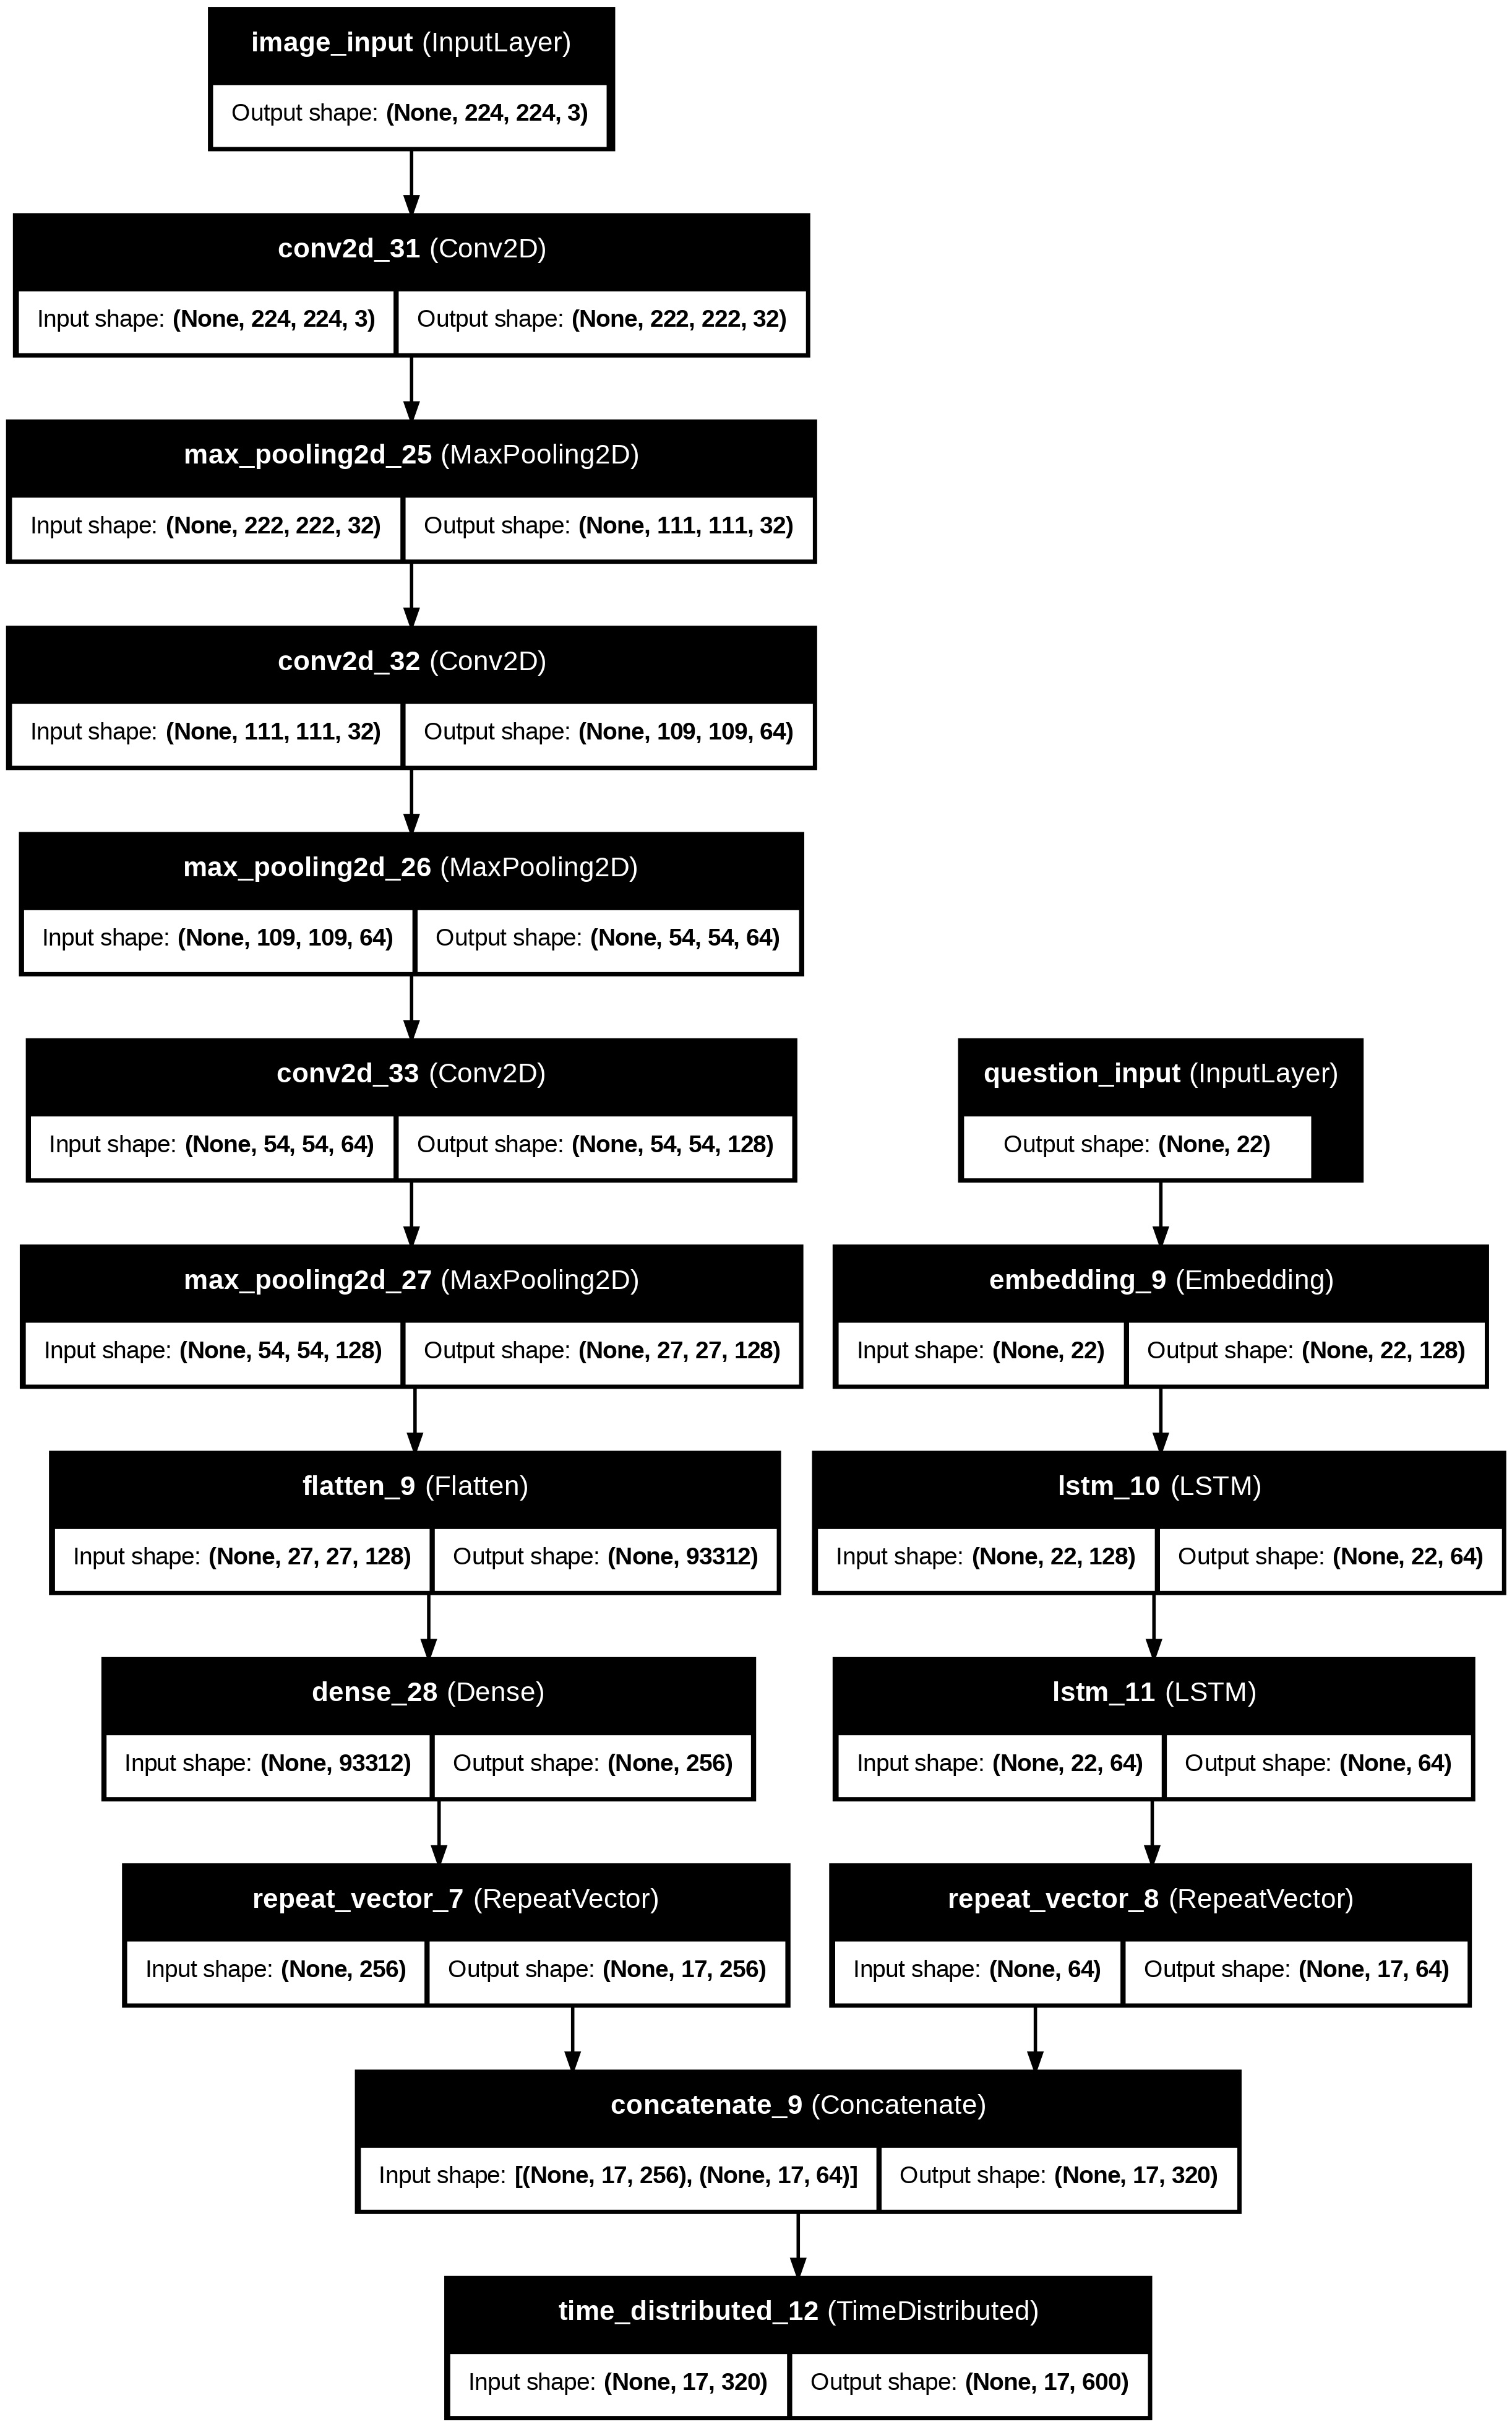

In [ ]:
plot_model(
    model_5_open,
    to_file='model_5_open_visualization.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
checkpoint, csv_logger = create_training_callbacks("model_5_open")



history = model_5_open.fit(
    [X_img_train_o, X_q_train_o],   # training inputs
    y_train_o,                                 # labels
    validation_data=([X_img_test_o, X_q_test_o], y_test_o),  # validation
    epochs=100,          # maximum epochs
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7242 - loss: 4.3716
Epoch 1: val_accuracy improved from -inf to 0.84768, saving model to model_5_open.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7281 - loss: 4.3102 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 2/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 2: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 3/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 3: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8518 - loss: 2.3885
Epoch 4: val_accuracy did not improve from 0.84768
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8522 - loss: 2.3819 - val_accuracy: 0.8477 - val_loss: 2.4552 - learning_rate: 0.0010
Epoch 5/100
23/24 ━━━━━━━━━━━

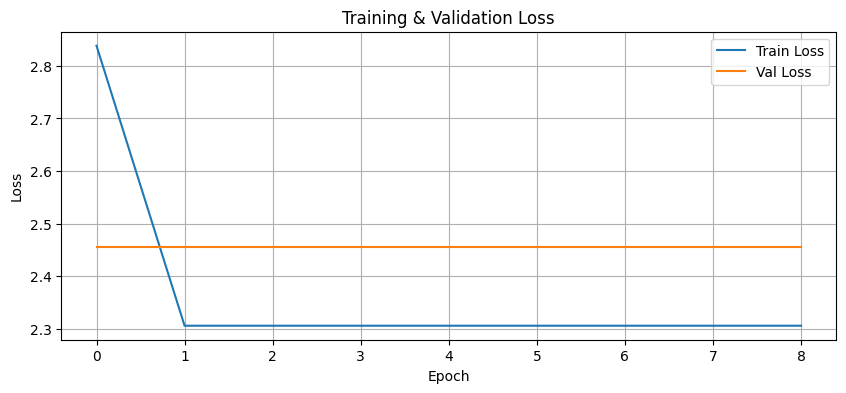

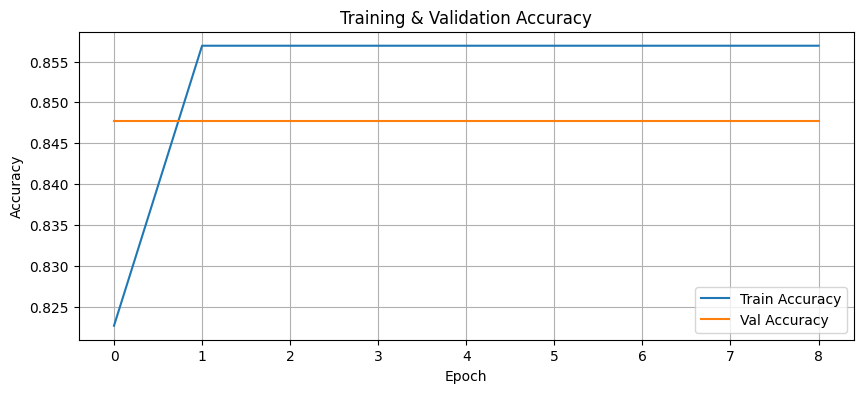

In [ ]:
# Load the CSV log
log = pd.read_csv('model_5_open.csv')

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['loss'], label='Train Loss')
plt.plot(log['epoch'], log['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(log['epoch'], log['accuracy'], label='Train Accuracy')
plt.plot(log['epoch'], log['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

---------END---------------------